In [1]:
import os
import time
import pandas as pd
import numpy as np
from random import sample
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from Bio import SeqIO
from multiprocessing import Process

import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU device:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("CPU device")

GPU device: NVIDIA GeForce RTX 3080 Laptop GPU


# device

In [3]:
dev = 'cuda'
dev2 = 'cpu'

# prep

In [4]:
clade_info = pd.read_csv('clade_info_2.csv',
                         index_col = 0,
                         header = None)
# clade_info

clade = {}

for x in set(clade_info.iloc[:, 0]):
    clade[x] = []

for x in list(clade_info.index):
    clade[clade_info.loc[x, 1]].append(x)

In [5]:
for x in clade.keys():
    print(len(clade[x]))

188
183
190
186
190
190


In [6]:
train_set = []
test_set = []

total_each = 130
for_train = 80

for x in clade.keys():
    to = sample(clade[x], total_each)# 每个类取 个
    train_set.extend(to[0: for_train])# 给训练集 个
    test_set.extend(to[for_train: ])# 给测试集 个
    
print(len(train_set))
print(len(test_set))

480
300


In [7]:
softmax = {'A': [1,0,0,0,0,0], 
           'B1': [0,1,0,0,0,0], 
           'B2': [0,0,1,0,0,0],
           'D': [0,0,0,1,0,0],
           'E': [0,0,0,0,1,0],
           'N9': [0,0,0,0,0,1],}

bo_d = {}

for x in softmax.keys():
    if x == 'B2':
        bo_d[x] = [1]
    else:
        bo_d[x] = [0]

# load

In [8]:
to_stack_x = []
to_stack_y = []

count = 0

for x in train_set:
    path = 'np/'
    
#     to_stack_x.append(torch.tensor(torch.load(path
#                                               + x 
#                                               + '.pt'
#                                              )
#                                   ).to(device = dev)
#                      )
    
    to_stack_x.append(torch.load(path + x + '.pt'
                                ).clone().detach().to(device = dev)
                     )
    
    to_stack_y.append(softmax[clade_info.loc[x, 1]
                              ]
                     )

#     to_stack_y.append(bo_d[clade_info.loc[x, 1]
#                               ]
#                      )
                                               
    
    print(count)
    count += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [9]:
to_stack_x_test = []
to_stack_y_test = []

count = 0

for x in test_set:
    path = 'np/'
    
    to_stack_x_test.append(torch.load(path + x + '.pt'
                                ).clone().detach().to(device = dev)
                     )
                                               
    to_stack_y_test.append(softmax[clade_info.loc[x, 1]
                                  ]
                     )

#     to_stack_y_test.append(bo_d[clade_info.loc[x, 1]
#                               ]
#                      )
    print(count)
    count += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

path = 'np/'

t = torch.from_numpy(np.load(path + '11128.npy')
                    ).type(torch.FloatTensor).to(device = dev)

len(t[0])
t.shape

In [10]:
train_x = torch.stack((to_stack_x))
test_x = torch.stack((to_stack_x_test))

In [11]:
del to_stack_x
del to_stack_x_test

In [12]:
train_x = train_x.reshape(len(train_set), 1, 4, 614129)
test_x = test_x.reshape(len(test_set), 1, 4, 614129)

In [13]:
train_y = torch.FloatTensor(to_stack_y).to(device = dev)
test_y = torch.FloatTensor(to_stack_y_test).to(device = dev)

In [14]:
del to_stack_y
del to_stack_y_test

# model

In [15]:
# ```Python
class the_model(nn.Module):

    def __init__(self):
        super(the_model, self).__init__()
        
#         self.dropout = nn.Dropout(p = 0.2)
        
        self.conv1 = nn.Conv2d(in_channels = 1,
                               out_channels = 6,
                               kernel_size = (4, 46),
                               stride = 9
                              ).to(torch.device(dev))
        
        self.mp1 = nn.MaxPool2d(kernel_size = (1, 31), 
                                stride = 5
                               ).to(torch.device(dev)
                                   )
        
        
        self.conv2 = nn.Conv2d(in_channels = 6,
                               out_channels = 1,
                               kernel_size = (1, 6),
#                                stride = 1
                              ).to(torch.device(dev))
        
        self.mp2 = nn.MaxPool2d(kernel_size = (1, 10),
                    stride = 2).to(torch.device(dev))
        
        
        self.conv3 = nn.Conv2d(in_channels = 1,
                               out_channels = 1,
                               kernel_size = (1, 3),
#                                stride = 1
                              ).to(torch.device(dev)
                                  )
                                   
        self.mp3 = nn.MaxPool2d(kernel_size = (1, 20),
                                stride = 5).to(torch.device(dev)
                                              )
                                   
        self.conv4 = nn.Conv2d(in_channels = 1,
                               out_channels = 1,
                               kernel_size = (1, 3),
#                                stride = 1
                              ).to(torch.device(dev)
                                  )
        self.mp4 = nn.MaxPool2d(kernel_size = (1, 30),
                                stride = 10).to(torch.device(dev)
                                               )
        
        self.fc1 = nn.Linear(133, 
                             6
                            ).to(torch.device(dev)
                                )
        
#         self.fc2 = nn.Linear(in_features = 1000, 
#                              out_features = 6
#                             ).to(torch.device(dev)
#                                 )
        
    def forward(self, x):
        
        x = self.conv1(x)
#         x = self.dropout(x)
        x = self.mp1(x)
        
        x = self.conv2(x)
#         x = self.dropout(x)
        x = self.mp2(x)
        
        x = self.conv3(x)
#         x = self.dropout(x)
        x = self.mp3(x)
                                   
        x = self.conv4(x)
#         x = self.dropout(x)
        x = self.mp4(x)
        
        x = torch.flatten(x, 1)
#         x = self.dropout(x)
        
        x = self.fc1(x)
#         x = self.fc2(x)
#         x = self.fc3(x)
#         x = self.fc4(x)
        
#         x = self.bo(x)
        
        return x
# ```

In [16]:
net = the_model()

In [17]:
loss_function = nn.CrossEntropyLoss().to(torch.device(dev))
# loss_function = nn.MSELoss().to(torch.device(dev))
# loss_function = nn.BCELoss().to(torch.device(dev))
optimizer = torch.optim.Adam(net.parameters(), 
                             lr = 8e-3,
                             weight_decay = 0 # 3e-2 
                            )

In [18]:
m1 = nn.Sigmoid()
m2 = nn.Softmax(dim = 1)

In [19]:
print(len(train_set))
print(len(test_set))

480
300


0
Wed Feb  8 23:18:27 2023
train loss: 1.819051742553711
test loss: 1.819017767906189
predict right count in train: tensor(80, device='cuda:0')
predict right count in test: tensor(50, device='cuda:0')


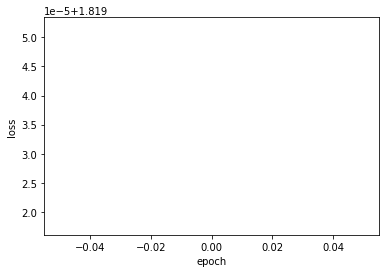

1
Wed Feb  8 23:18:29 2023
train loss: 1.829565405845642
test loss: 1.82960844039917
predict right count in train: tensor(80, device='cuda:0')
predict right count in test: tensor(50, device='cuda:0')


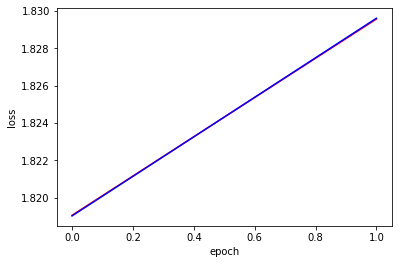

2
Wed Feb  8 23:18:29 2023
train loss: 1.8145464658737183
test loss: 1.814536213874817
predict right count in train: tensor(80, device='cuda:0')
predict right count in test: tensor(50, device='cuda:0')


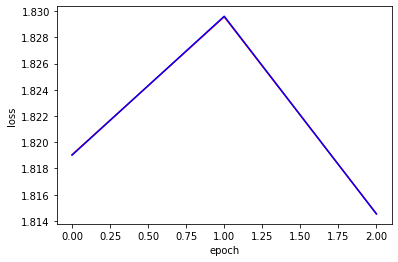

3
Wed Feb  8 23:18:30 2023
train loss: 1.7981173992156982
test loss: 1.7981460094451904
predict right count in train: tensor(80, device='cuda:0')
predict right count in test: tensor(50, device='cuda:0')


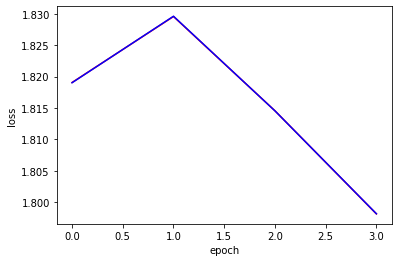

4
Wed Feb  8 23:18:30 2023
train loss: 1.8031731843948364
test loss: 1.803205966949463
predict right count in train: tensor(80, device='cuda:0')
predict right count in test: tensor(50, device='cuda:0')


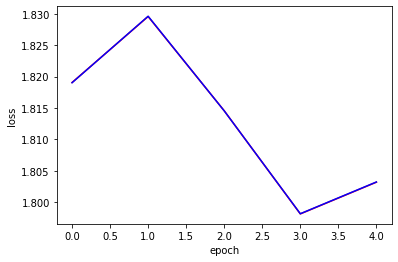

5
Wed Feb  8 23:18:30 2023
train loss: 1.8059251308441162
test loss: 1.8059766292572021
predict right count in train: tensor(80, device='cuda:0')
predict right count in test: tensor(50, device='cuda:0')


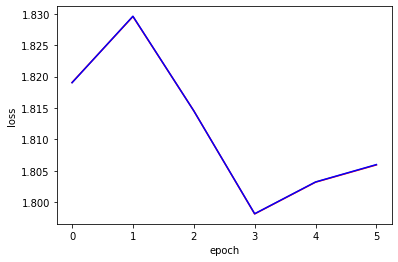

6
Wed Feb  8 23:18:30 2023
train loss: 1.8012559413909912
test loss: 1.8012982606887817
predict right count in train: tensor(80, device='cuda:0')
predict right count in test: tensor(50, device='cuda:0')


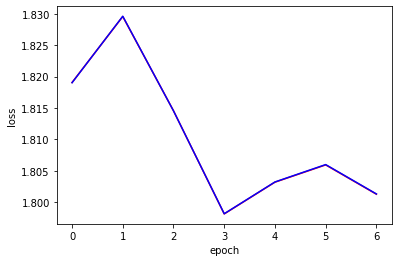

7
Wed Feb  8 23:18:31 2023
train loss: 1.7962344884872437
test loss: 1.7962669134140015
predict right count in train: tensor(80, device='cuda:0')
predict right count in test: tensor(50, device='cuda:0')


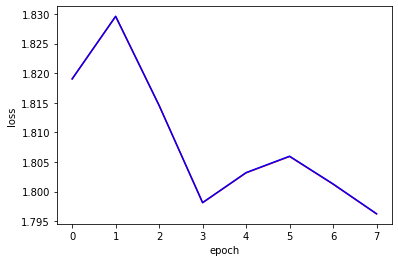

8
Wed Feb  8 23:18:31 2023
train loss: 1.794968605041504
test loss: 1.7949854135513306
predict right count in train: tensor(80, device='cuda:0')
predict right count in test: tensor(50, device='cuda:0')


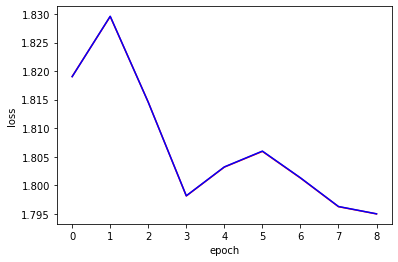

9
Wed Feb  8 23:18:31 2023
train loss: 1.7956230640411377
test loss: 1.7956476211547852
predict right count in train: tensor(80, device='cuda:0')
predict right count in test: tensor(50, device='cuda:0')


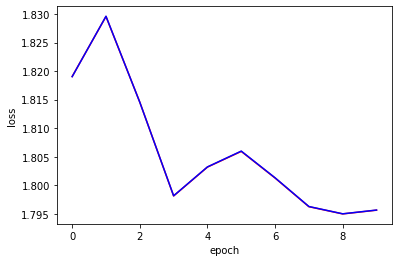

10
Wed Feb  8 23:18:31 2023
train loss: 1.7956851720809937
test loss: 1.7957271337509155
predict right count in train: tensor(80, device='cuda:0')
predict right count in test: tensor(50, device='cuda:0')


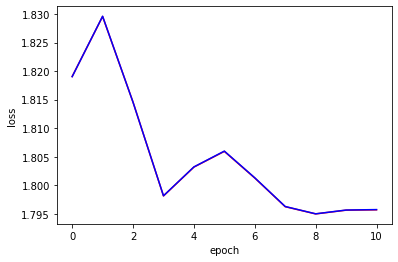

11
Wed Feb  8 23:18:32 2023
train loss: 1.794329285621643
test loss: 1.7943849563598633
predict right count in train: tensor(80, device='cuda:0')
predict right count in test: tensor(50, device='cuda:0')


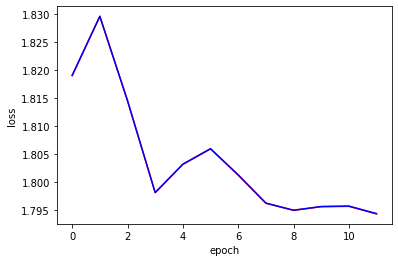

12
Wed Feb  8 23:18:32 2023
train loss: 1.792378306388855
test loss: 1.7924631834030151
predict right count in train: tensor(80, device='cuda:0')
predict right count in test: tensor(50, device='cuda:0')


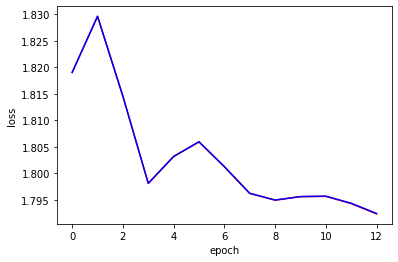

13
Wed Feb  8 23:18:32 2023
train loss: 1.7906569242477417
test loss: 1.7907696962356567
predict right count in train: tensor(80, device='cuda:0')
predict right count in test: tensor(50, device='cuda:0')


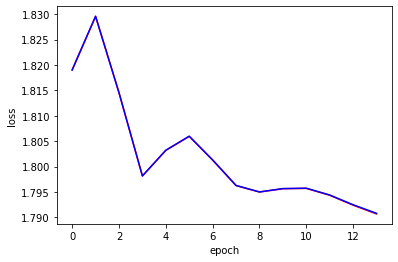

14
Wed Feb  8 23:18:32 2023
train loss: 1.789419412612915
test loss: 1.789538025856018
predict right count in train: tensor(80, device='cuda:0')
predict right count in test: tensor(50, device='cuda:0')


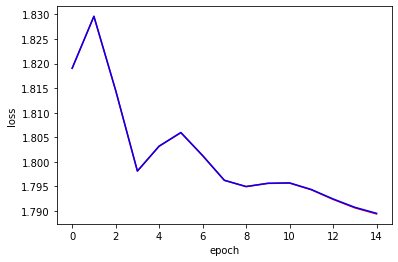

15
Wed Feb  8 23:18:33 2023
train loss: 1.7890689373016357
test loss: 1.7892159223556519
predict right count in train: tensor(133, device='cuda:0')
predict right count in test: tensor(82, device='cuda:0')


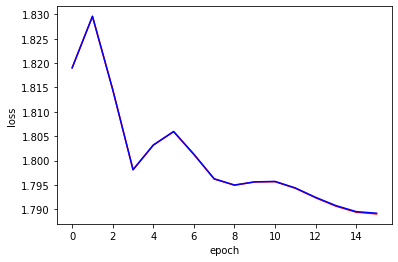

16
Wed Feb  8 23:18:33 2023
train loss: 1.7875511646270752
test loss: 1.7877159118652344
predict right count in train: tensor(158, device='cuda:0')
predict right count in test: tensor(96, device='cuda:0')


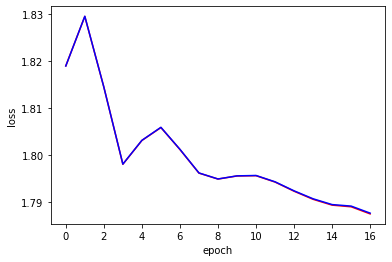

17
Wed Feb  8 23:18:33 2023
train loss: 1.7855454683303833
test loss: 1.785719871520996
predict right count in train: tensor(160, device='cuda:0')
predict right count in test: tensor(99, device='cuda:0')


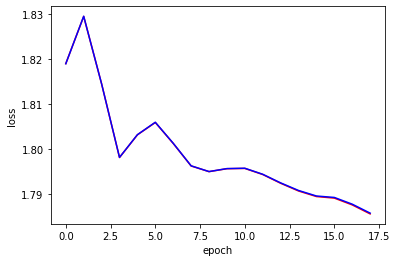

18
Wed Feb  8 23:18:33 2023
train loss: 1.7835924625396729
test loss: 1.7837754487991333
predict right count in train: tensor(160, device='cuda:0')
predict right count in test: tensor(100, device='cuda:0')


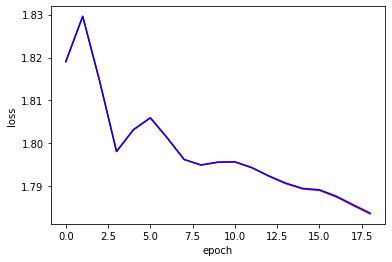

19
Wed Feb  8 23:18:34 2023
train loss: 1.7813301086425781
test loss: 1.7815401554107666
predict right count in train: tensor(224, device='cuda:0')
predict right count in test: tensor(136, device='cuda:0')


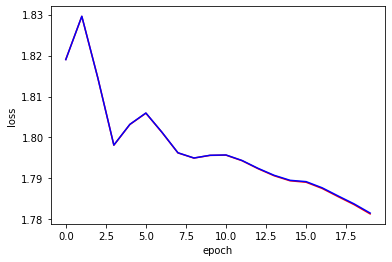

20
Wed Feb  8 23:18:34 2023
train loss: 1.7784322500228882
test loss: 1.7787426710128784
predict right count in train: tensor(80, device='cuda:0')
predict right count in test: tensor(50, device='cuda:0')


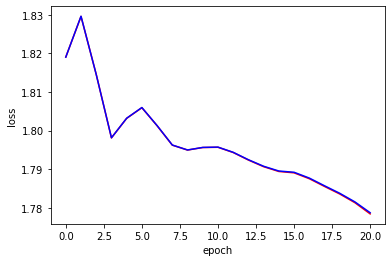

21
Wed Feb  8 23:18:34 2023
train loss: 1.7756203413009644
test loss: 1.7759631872177124
predict right count in train: tensor(80, device='cuda:0')
predict right count in test: tensor(50, device='cuda:0')


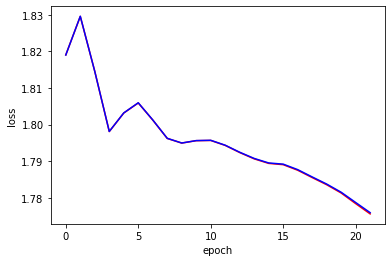

22
Wed Feb  8 23:18:34 2023
train loss: 1.772067666053772
test loss: 1.7723416090011597
predict right count in train: tensor(80, device='cuda:0')
predict right count in test: tensor(50, device='cuda:0')


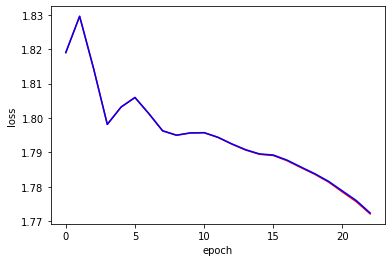

23
Wed Feb  8 23:18:34 2023
train loss: 1.7673307657241821
test loss: 1.7676430940628052
predict right count in train: tensor(98, device='cuda:0')
predict right count in test: tensor(62, device='cuda:0')


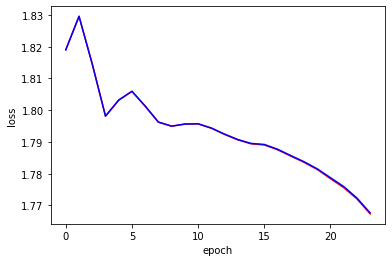

24
Wed Feb  8 23:18:35 2023
train loss: 1.7615373134613037
test loss: 1.7619147300720215
predict right count in train: tensor(183, device='cuda:0')
predict right count in test: tensor(107, device='cuda:0')


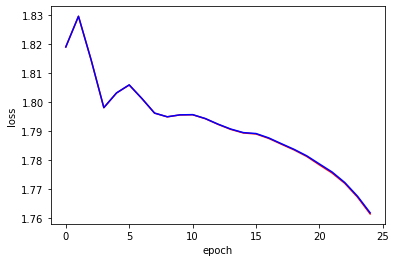

25
Wed Feb  8 23:18:35 2023
train loss: 1.7543493509292603
test loss: 1.754875898361206
predict right count in train: tensor(234, device='cuda:0')
predict right count in test: tensor(147, device='cuda:0')


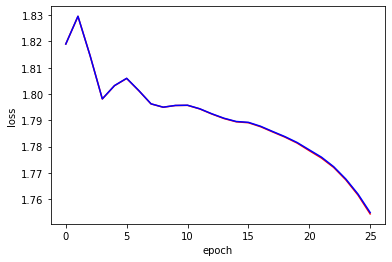

26
Wed Feb  8 23:18:35 2023
train loss: 1.7447746992111206
test loss: 1.7455379962921143
predict right count in train: tensor(330, device='cuda:0')
predict right count in test: tensor(198, device='cuda:0')


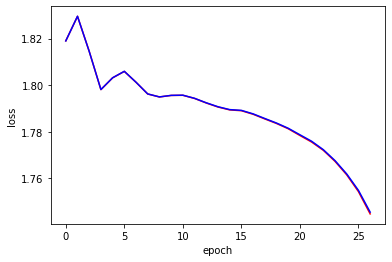

27
Wed Feb  8 23:18:35 2023
train loss: 1.7322335243225098
test loss: 1.7331864833831787
predict right count in train: tensor(459, device='cuda:0')
predict right count in test: tensor(283, device='cuda:0')


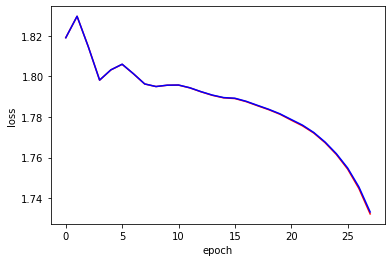

28
Wed Feb  8 23:18:36 2023
train loss: 1.717307209968567
test loss: 1.7185057401657104
predict right count in train: tensor(401, device='cuda:0')
predict right count in test: tensor(252, device='cuda:0')


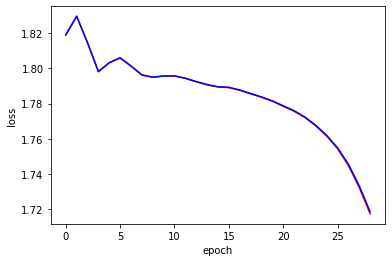

29
Wed Feb  8 23:18:36 2023
train loss: 1.6972354650497437
test loss: 1.6984283924102783
predict right count in train: tensor(452, device='cuda:0')
predict right count in test: tensor(281, device='cuda:0')


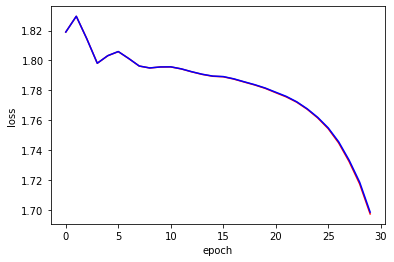

30
Wed Feb  8 23:18:36 2023
train loss: 1.6744121313095093
test loss: 1.6759849786758423
predict right count in train: tensor(430, device='cuda:0')
predict right count in test: tensor(263, device='cuda:0')


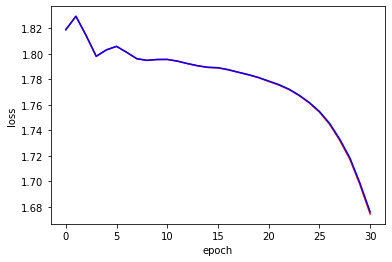

31
Wed Feb  8 23:18:36 2023
train loss: 1.6435751914978027
test loss: 1.6454520225524902
predict right count in train: tensor(418, device='cuda:0')
predict right count in test: tensor(265, device='cuda:0')


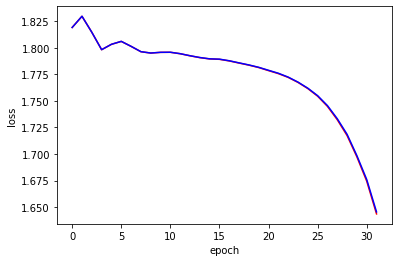

32
Wed Feb  8 23:18:36 2023
train loss: 1.6025892496109009
test loss: 1.6047351360321045
predict right count in train: tensor(395, device='cuda:0')
predict right count in test: tensor(246, device='cuda:0')


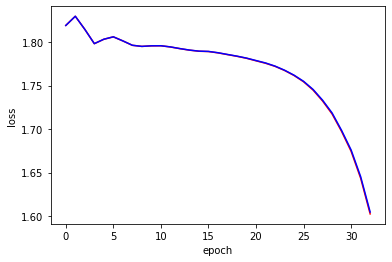

33
Wed Feb  8 23:18:37 2023
train loss: 1.5604153871536255
test loss: 1.5627174377441406
predict right count in train: tensor(399, device='cuda:0')
predict right count in test: tensor(249, device='cuda:0')


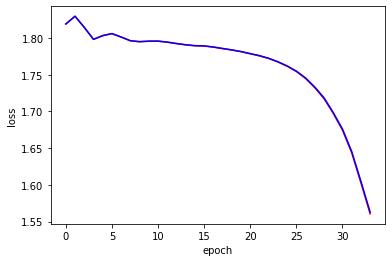

34
Wed Feb  8 23:18:37 2023
train loss: 1.4988231658935547
test loss: 1.5015555620193481
predict right count in train: tensor(407, device='cuda:0')
predict right count in test: tensor(253, device='cuda:0')


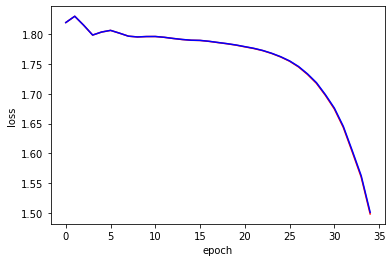

35
Wed Feb  8 23:18:37 2023
train loss: 1.4261335134506226
test loss: 1.4293310642242432
predict right count in train: tensor(396, device='cuda:0')
predict right count in test: tensor(245, device='cuda:0')


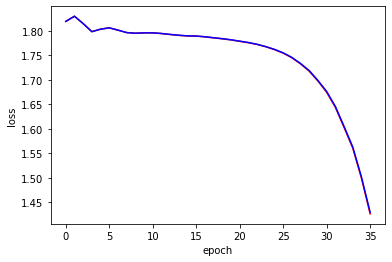

36
Wed Feb  8 23:18:37 2023
train loss: 1.3434815406799316
test loss: 1.346919298171997
predict right count in train: tensor(398, device='cuda:0')
predict right count in test: tensor(249, device='cuda:0')


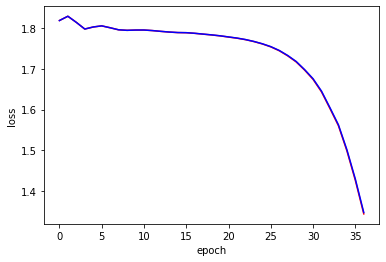

37
Wed Feb  8 23:18:38 2023
train loss: 1.2394118309020996
test loss: 1.2430113554000854
predict right count in train: tensor(445, device='cuda:0')
predict right count in test: tensor(285, device='cuda:0')


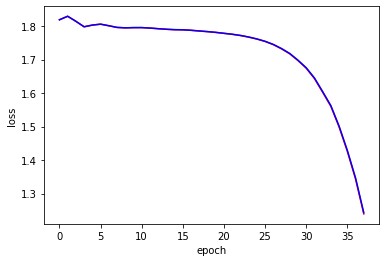

38
Wed Feb  8 23:18:38 2023
train loss: 1.1220365762710571
test loss: 1.1272090673446655
predict right count in train: tensor(458, device='cuda:0')
predict right count in test: tensor(292, device='cuda:0')


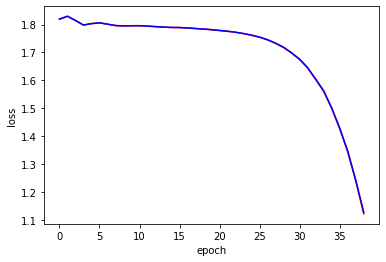

39
Wed Feb  8 23:18:38 2023
train loss: 0.9919536113739014
test loss: 0.9967777729034424
predict right count in train: tensor(457, device='cuda:0')
predict right count in test: tensor(292, device='cuda:0')


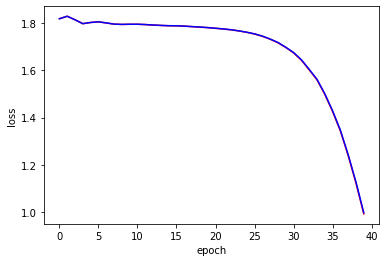

40
Wed Feb  8 23:18:38 2023
train loss: 0.8467607498168945
test loss: 0.850861668586731
predict right count in train: tensor(465, device='cuda:0')
predict right count in test: tensor(292, device='cuda:0')


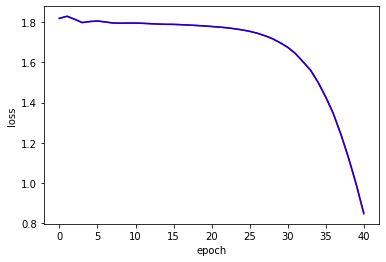

41
Wed Feb  8 23:18:38 2023
train loss: 0.6985236406326294
test loss: 0.7014743089675903
predict right count in train: tensor(470, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


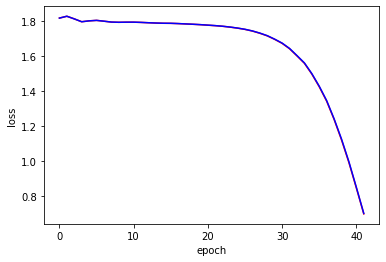

42
Wed Feb  8 23:18:39 2023
train loss: 0.5630287528038025
test loss: 0.5659464597702026
predict right count in train: tensor(470, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


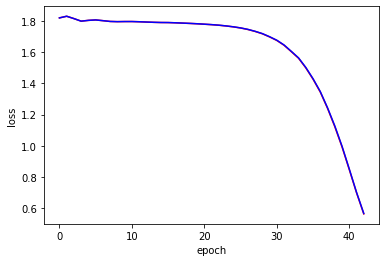

43
Wed Feb  8 23:18:39 2023
train loss: 0.4444025158882141
test loss: 0.44631898403167725
predict right count in train: tensor(471, device='cuda:0')
predict right count in test: tensor(294, device='cuda:0')


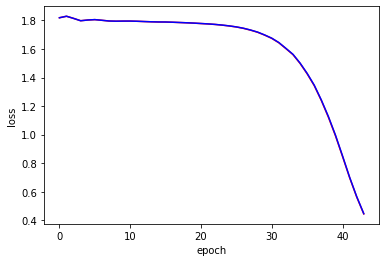

44
Wed Feb  8 23:18:39 2023
train loss: 0.3314802944660187
test loss: 0.33411088585853577
predict right count in train: tensor(471, device='cuda:0')
predict right count in test: tensor(295, device='cuda:0')


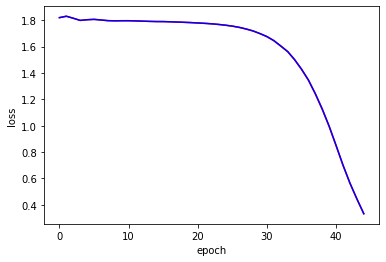

45
Wed Feb  8 23:18:39 2023
train loss: 0.24731004238128662
test loss: 0.24775299429893494
predict right count in train: tensor(474, device='cuda:0')
predict right count in test: tensor(297, device='cuda:0')


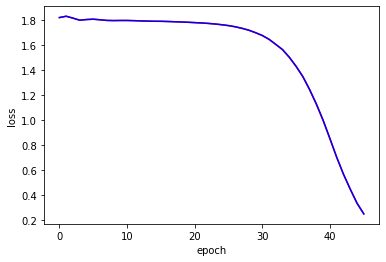

46
Wed Feb  8 23:18:40 2023
train loss: 0.1812259703874588
test loss: 0.17879745364189148
predict right count in train: tensor(476, device='cuda:0')
predict right count in test: tensor(297, device='cuda:0')


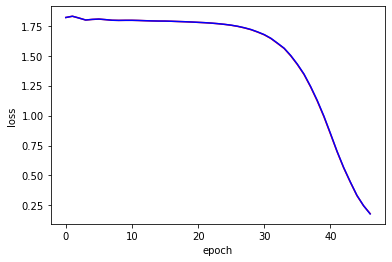

47
Wed Feb  8 23:18:40 2023
train loss: 0.1310865581035614
test loss: 0.12677811086177826
predict right count in train: tensor(477, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


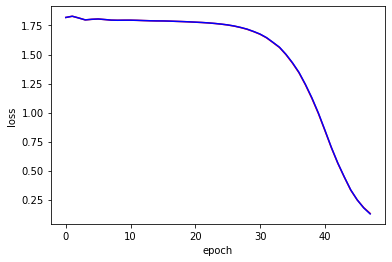

48
Wed Feb  8 23:18:40 2023
train loss: 0.09452805668115616
test loss: 0.0888766273856163
predict right count in train: tensor(478, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


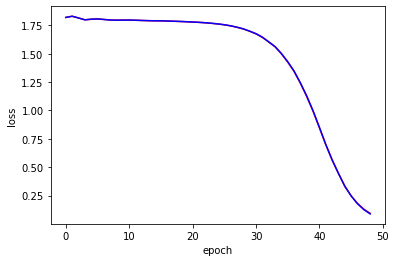

49
Wed Feb  8 23:18:40 2023
train loss: 0.06730817258358002
test loss: 0.061469245702028275
predict right count in train: tensor(479, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


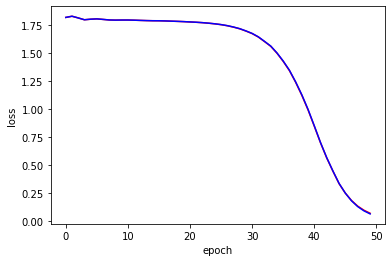

50
Wed Feb  8 23:18:40 2023
train loss: 0.047273971140384674
test loss: 0.04387698695063591
predict right count in train: tensor(479, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


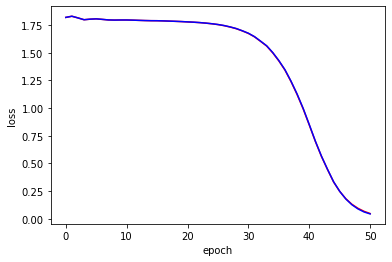

51
Wed Feb  8 23:18:41 2023
train loss: 0.03396408632397652
test loss: 0.033100154250860214
predict right count in train: tensor(479, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


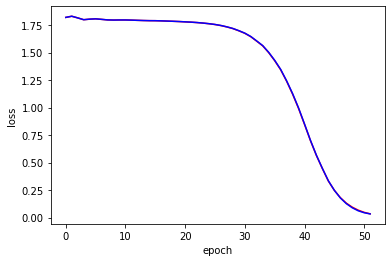

52
Wed Feb  8 23:18:41 2023
train loss: 0.02425743266940117
test loss: 0.024501662701368332
predict right count in train: tensor(479, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


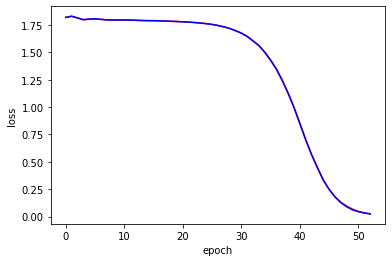

53
Wed Feb  8 23:18:41 2023
train loss: 0.018323112279176712
test loss: 0.019433768466114998
predict right count in train: tensor(479, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


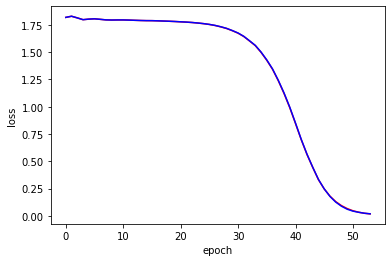

54
Wed Feb  8 23:18:41 2023
train loss: 0.013673897832632065
test loss: 0.016859136521816254
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


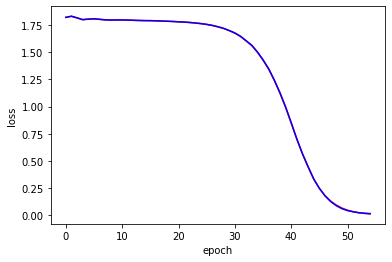

55
Wed Feb  8 23:18:42 2023
train loss: 0.010572684928774834
test loss: 0.016002332791686058
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


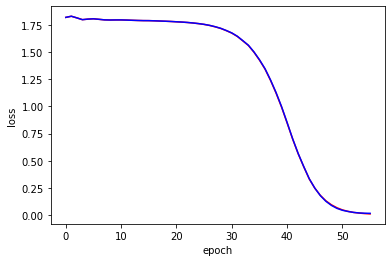

56
Wed Feb  8 23:18:42 2023
train loss: 0.0080720828846097
test loss: 0.014790921472012997
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


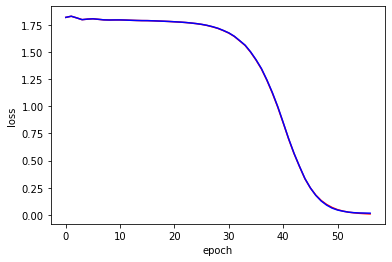

57
Wed Feb  8 23:18:42 2023
train loss: 0.006059613078832626
test loss: 0.013064717873930931
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


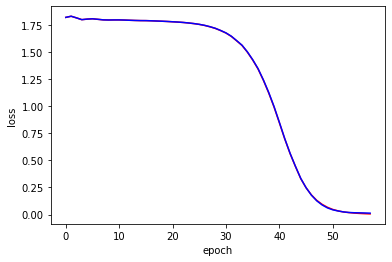

58
Wed Feb  8 23:18:42 2023
train loss: 0.004656209610402584
test loss: 0.01176136638969183
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


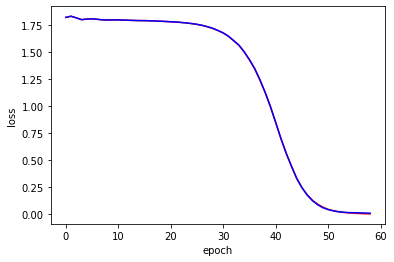

59
Wed Feb  8 23:18:43 2023
train loss: 0.0035501685924828053
test loss: 0.011368945240974426
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


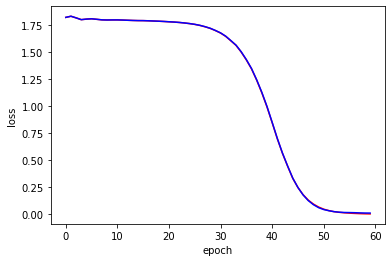

60
Wed Feb  8 23:18:43 2023
train loss: 0.0027075426187366247
test loss: 0.011815289966762066
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


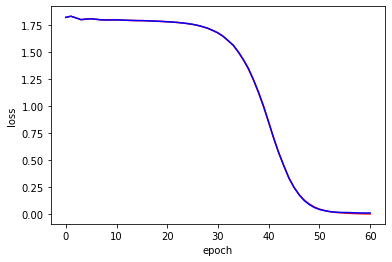

61
Wed Feb  8 23:18:43 2023
train loss: 0.00213748961687088
test loss: 0.01270997803658247
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


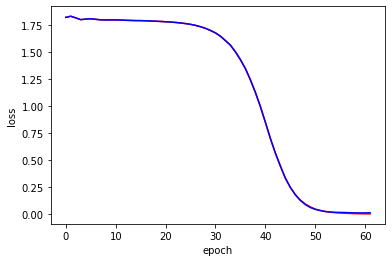

62
Wed Feb  8 23:18:43 2023
train loss: 0.0017349182162433863
test loss: 0.013367562554776669
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


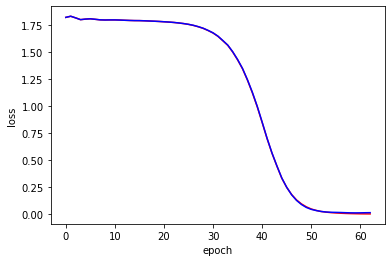

63
Wed Feb  8 23:18:43 2023
train loss: 0.0013860577018931508
test loss: 0.013565936125814915
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


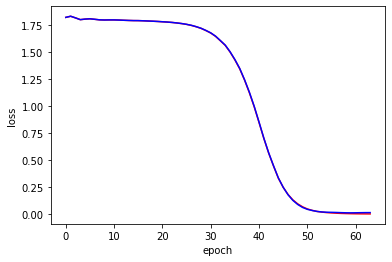

64
Wed Feb  8 23:18:44 2023
train loss: 0.0010933014564216137
test loss: 0.013369759544730186
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


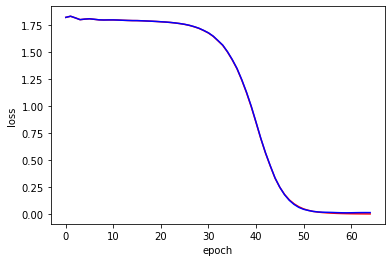

65
Wed Feb  8 23:18:44 2023
train loss: 0.0008843662217259407
test loss: 0.01299429964274168
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


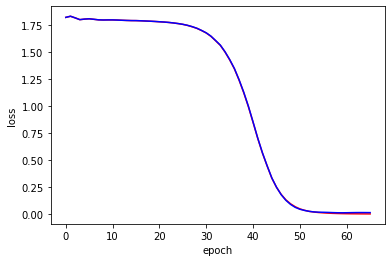

66
Wed Feb  8 23:18:44 2023
train loss: 0.0007409233949147165
test loss: 0.012502674013376236
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


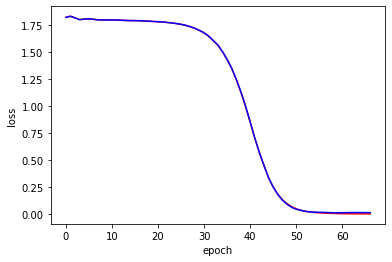

67
Wed Feb  8 23:18:44 2023
train loss: 0.0006337542436085641
test loss: 0.012018227949738503
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


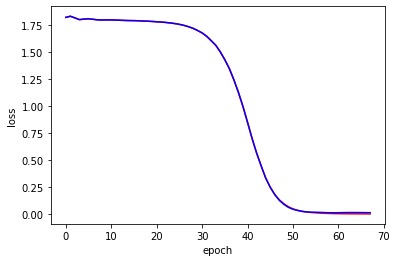

68
Wed Feb  8 23:18:45 2023
train loss: 0.0005419622175395489
test loss: 0.011763474904000759
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


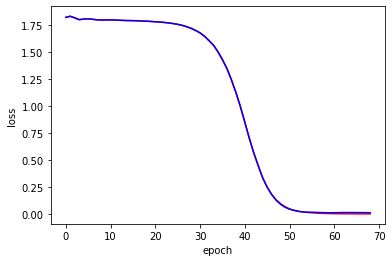

69
Wed Feb  8 23:18:45 2023
train loss: 0.00045959840645082295
test loss: 0.011710282415151596
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


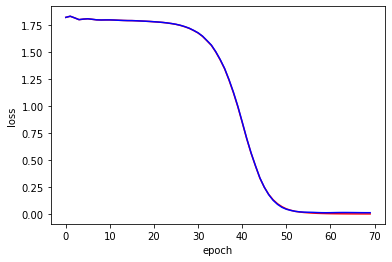

70
Wed Feb  8 23:18:45 2023
train loss: 0.00038829247932881117
test loss: 0.011752603575587273
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


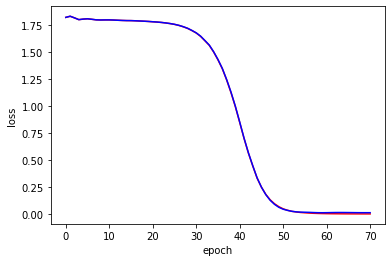

71
Wed Feb  8 23:18:45 2023
train loss: 0.000331351300701499
test loss: 0.011828744783997536
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


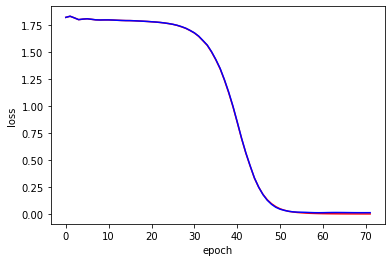

72
Wed Feb  8 23:18:46 2023
train loss: 0.0002872806217055768
test loss: 0.011903182603418827
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


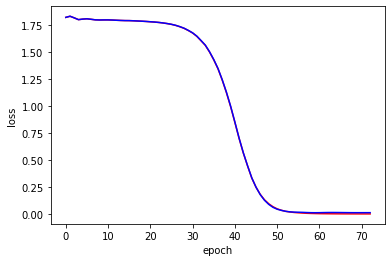

73
Wed Feb  8 23:18:46 2023
train loss: 0.0002553308440838009
test loss: 0.011952855624258518
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


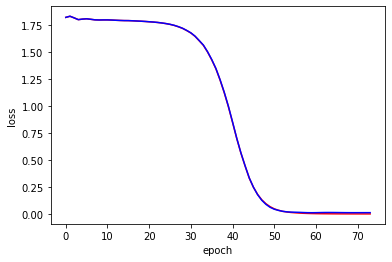

74
Wed Feb  8 23:18:46 2023
train loss: 0.0002293454308528453
test loss: 0.011936943046748638
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


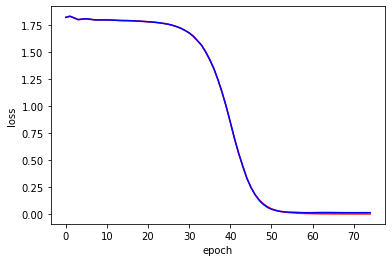

75
Wed Feb  8 23:18:46 2023
train loss: 0.00020743378263432533
test loss: 0.011843657121062279
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


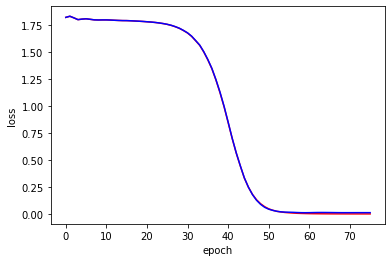

76
Wed Feb  8 23:18:46 2023
train loss: 0.0001880747004179284
test loss: 0.01165517047047615
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


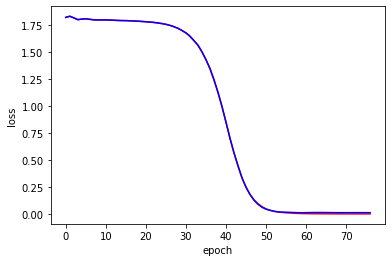

77
Wed Feb  8 23:18:47 2023
train loss: 0.0001723140594549477
test loss: 0.011419267393648624
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


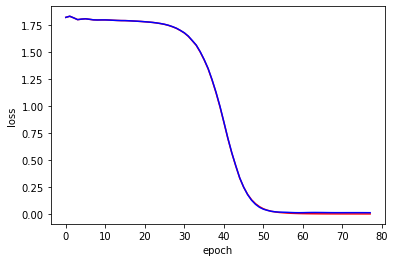

78
Wed Feb  8 23:18:47 2023
train loss: 0.00015875007375143468
test loss: 0.011113650165498257
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


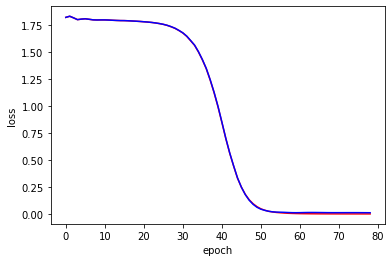

79
Wed Feb  8 23:18:47 2023
train loss: 0.0001469398703193292
test loss: 0.010753924958407879
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


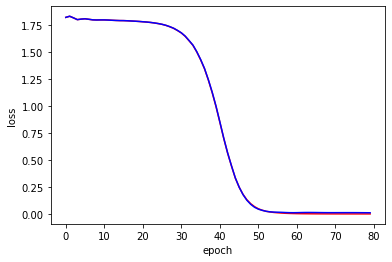

80
Wed Feb  8 23:18:47 2023
train loss: 0.00013674714136868715
test loss: 0.010373345576226711
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


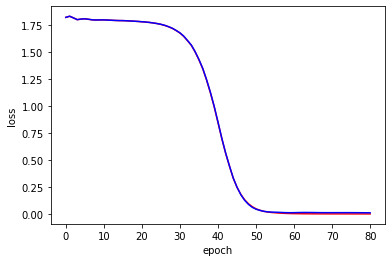

81
Wed Feb  8 23:18:48 2023
train loss: 0.0001284063619095832
test loss: 0.009992511011660099
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


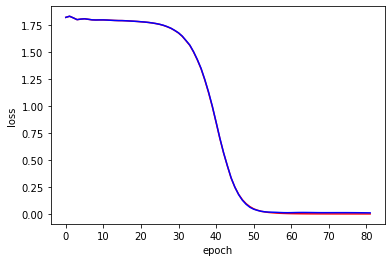

82
Wed Feb  8 23:18:48 2023
train loss: 0.00012151517876191065
test loss: 0.009633618406951427
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


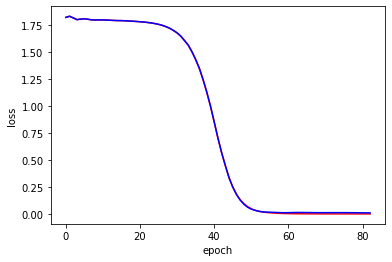

83
Wed Feb  8 23:18:48 2023
train loss: 0.0001158343002316542
test loss: 0.009305254556238651
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


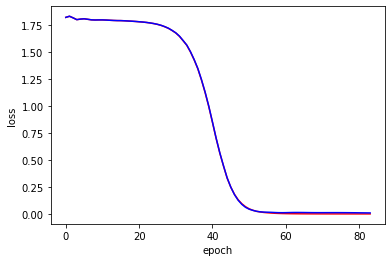

84
Wed Feb  8 23:18:48 2023
train loss: 0.00011100766278104857
test loss: 0.00903172604739666
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


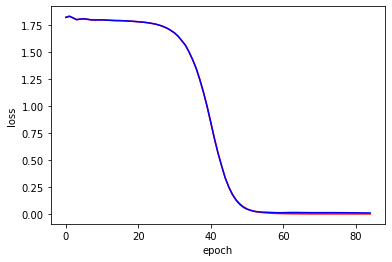

85
Wed Feb  8 23:18:49 2023
train loss: 0.00010678749822545797
test loss: 0.008819788694381714
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


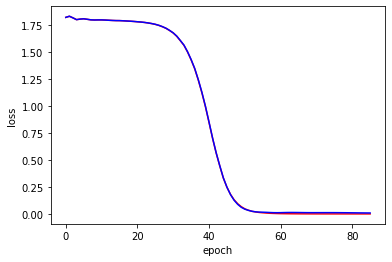

86
Wed Feb  8 23:18:49 2023
train loss: 0.00010284067684551701
test loss: 0.008665858767926693
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


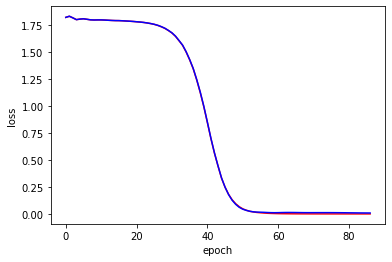

87
Wed Feb  8 23:18:49 2023
train loss: 9.906644118018448e-05
test loss: 0.00856607686728239
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


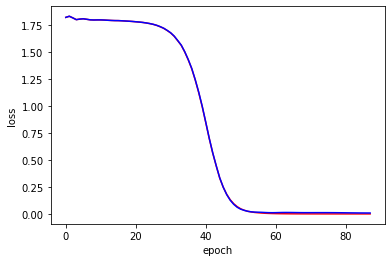

88
Wed Feb  8 23:18:49 2023
train loss: 9.548299567541108e-05
test loss: 0.008514649234712124
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


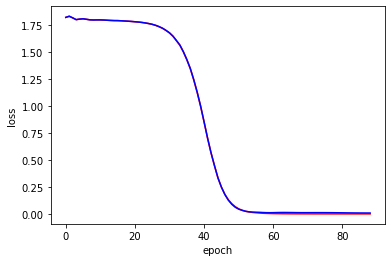

89
Wed Feb  8 23:18:49 2023
train loss: 9.208402479998767e-05
test loss: 0.008508631028234959
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


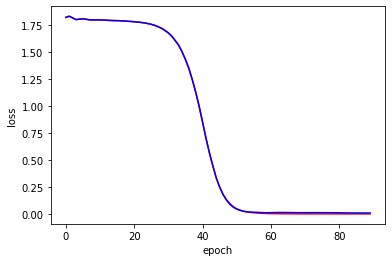

90
Wed Feb  8 23:18:50 2023
train loss: 8.894141501514241e-05
test loss: 0.008546074852347374
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


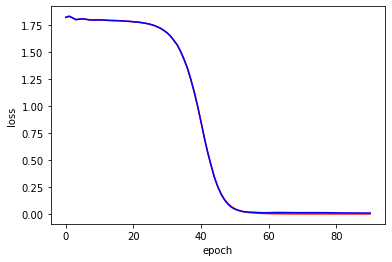

91
Wed Feb  8 23:18:50 2023
train loss: 8.602138404967263e-05
test loss: 0.008610498160123825
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


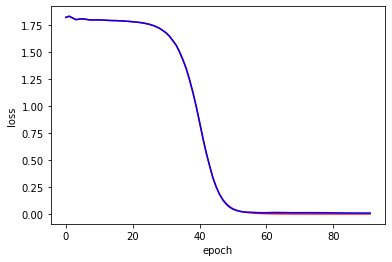

92
Wed Feb  8 23:18:50 2023
train loss: 8.335239544976503e-05
test loss: 0.00869656354188919
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


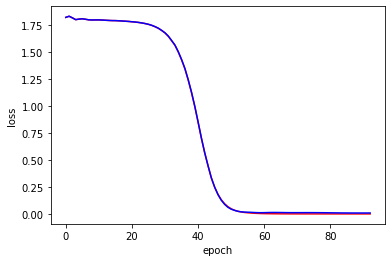

93
Wed Feb  8 23:18:50 2023
train loss: 8.096816600300372e-05
test loss: 0.008793641813099384
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


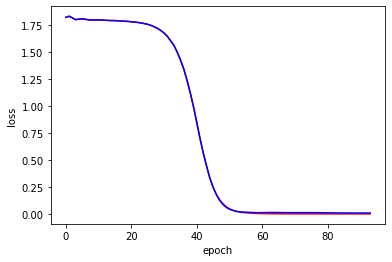

94
Wed Feb  8 23:18:51 2023
train loss: 7.883373473305255e-05
test loss: 0.00889270007610321
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


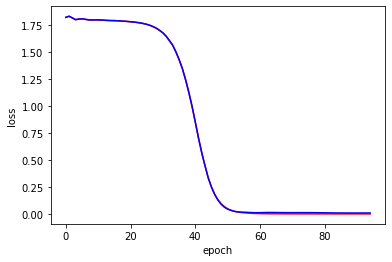

95
Wed Feb  8 23:18:51 2023
train loss: 7.692293002037331e-05
test loss: 0.00898707378655672
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


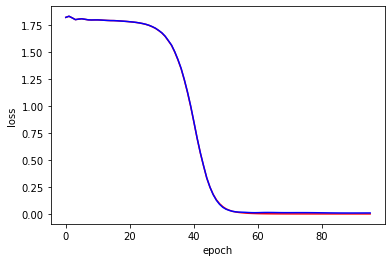

96
Wed Feb  8 23:18:51 2023
train loss: 7.518917118432e-05
test loss: 0.009072557091712952
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


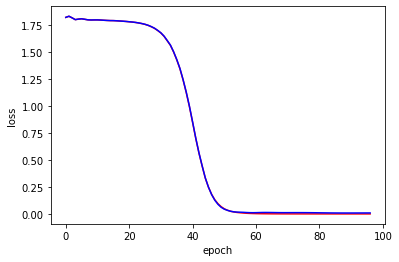

97
Wed Feb  8 23:18:51 2023
train loss: 7.361097959801555e-05
test loss: 0.009144926443696022
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


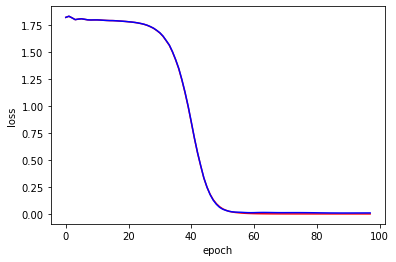

98
Wed Feb  8 23:18:51 2023
train loss: 7.212640048237517e-05
test loss: 0.009198881685733795
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


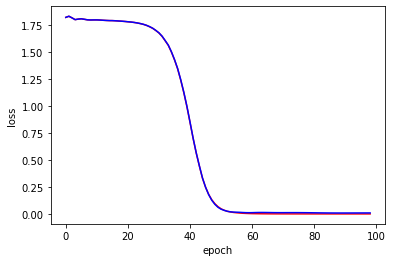

99
Wed Feb  8 23:18:52 2023
train loss: 7.071114669088274e-05
test loss: 0.009235221892595291
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


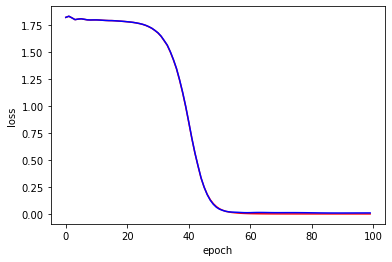

100
Wed Feb  8 23:18:52 2023
train loss: 6.93766342010349e-05
test loss: 0.009257388301193714
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


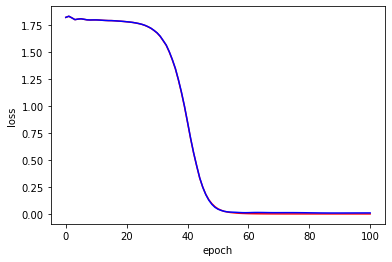

101
Wed Feb  8 23:18:52 2023
train loss: 6.809216574765742e-05
test loss: 0.009262043982744217
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


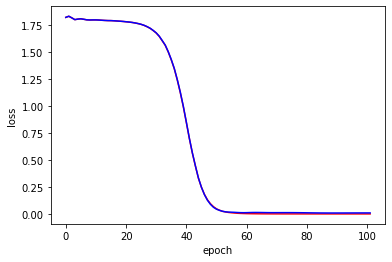

102
Wed Feb  8 23:18:52 2023
train loss: 6.68572320137173e-05
test loss: 0.009249687194824219
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


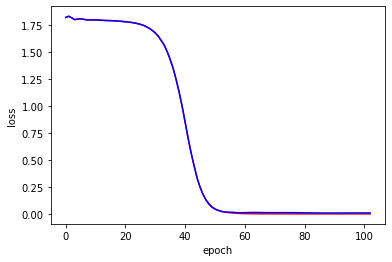

103
Wed Feb  8 23:18:53 2023
train loss: 6.567878153873608e-05
test loss: 0.00922367163002491
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


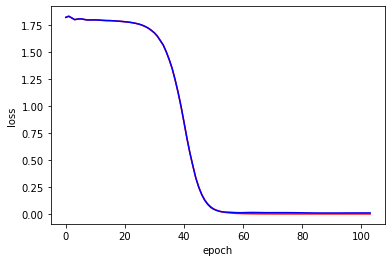

104
Wed Feb  8 23:18:53 2023
train loss: 6.456378469010815e-05
test loss: 0.00918822456151247
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


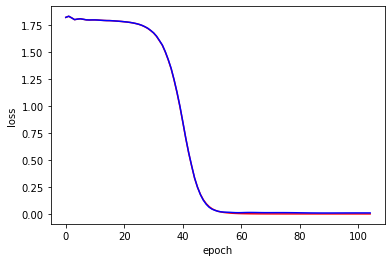

105
Wed Feb  8 23:18:53 2023
train loss: 6.354571814881638e-05
test loss: 0.009147112257778645
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


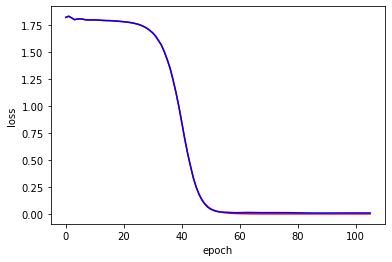

106
Wed Feb  8 23:18:53 2023
train loss: 6.26213732175529e-05
test loss: 0.009103503078222275
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


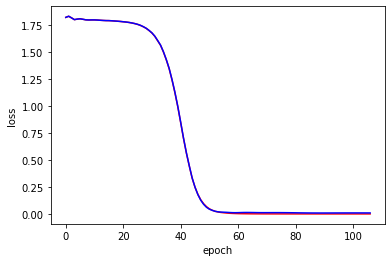

107
Wed Feb  8 23:18:54 2023
train loss: 6.176497845444828e-05
test loss: 0.009061048738658428
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


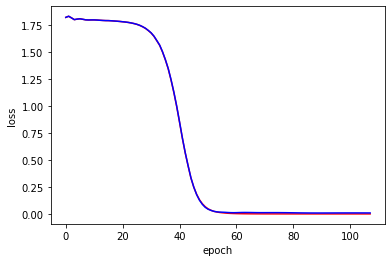

108
Wed Feb  8 23:18:54 2023
train loss: 6.0985199525021017e-05
test loss: 0.009024880826473236
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


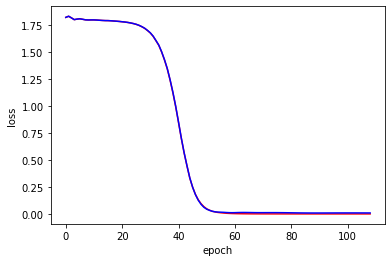

109
Wed Feb  8 23:18:54 2023
train loss: 6.025058246450499e-05
test loss: 0.008993876166641712
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


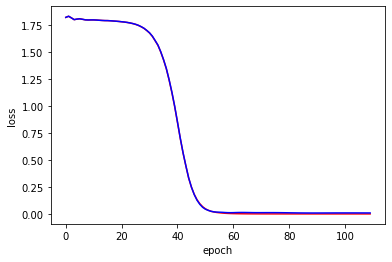

110
Wed Feb  8 23:18:54 2023
train loss: 5.9538058849284425e-05
test loss: 0.008969399146735668
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


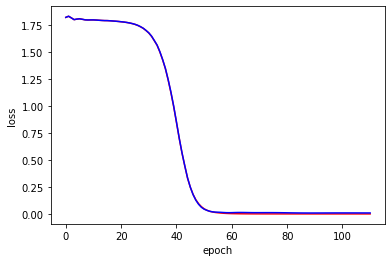

111
Wed Feb  8 23:18:55 2023
train loss: 5.886450890102424e-05
test loss: 0.008952440693974495
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


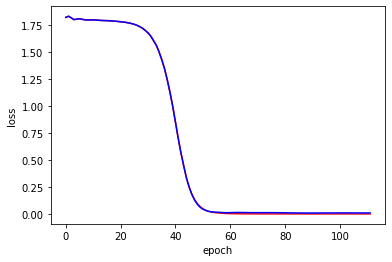

112
Wed Feb  8 23:18:55 2023
train loss: 5.82090942771174e-05
test loss: 0.008943453431129456
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


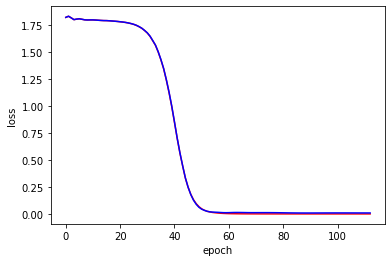

113
Wed Feb  8 23:18:55 2023
train loss: 5.759141276939772e-05
test loss: 0.008943167515099049
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


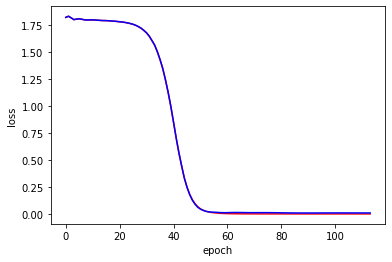

114
Wed Feb  8 23:18:55 2023
train loss: 5.702510316041298e-05
test loss: 0.008951138705015182
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


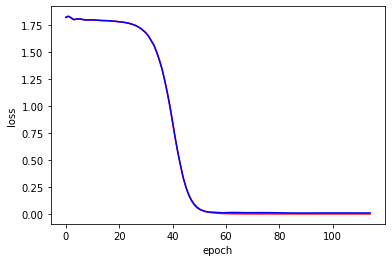

115
Wed Feb  8 23:18:55 2023
train loss: 5.646007048198953e-05
test loss: 0.008965159766376019
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


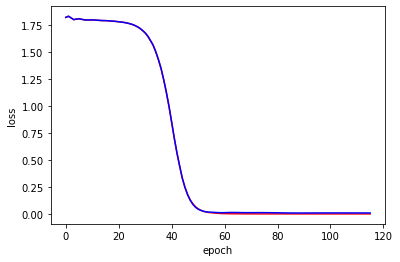

116
Wed Feb  8 23:18:56 2023
train loss: 5.590076762018725e-05
test loss: 0.008984309621155262
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


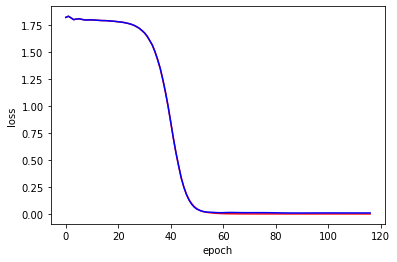

117
Wed Feb  8 23:18:56 2023
train loss: 5.536131720873527e-05
test loss: 0.009008830413222313
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


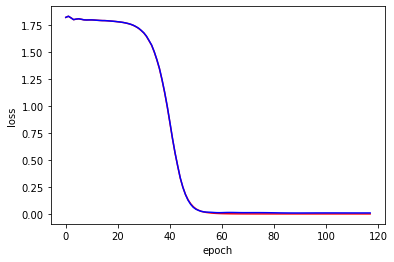

118
Wed Feb  8 23:18:56 2023
train loss: 5.48456737305969e-05
test loss: 0.009039122611284256
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


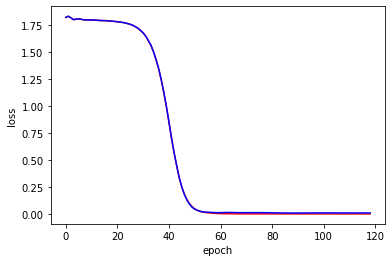

119
Wed Feb  8 23:18:56 2023
train loss: 5.433920523501001e-05
test loss: 0.009074201807379723
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


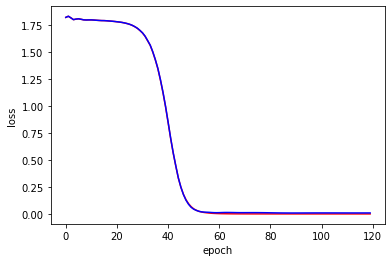

120
Wed Feb  8 23:18:57 2023
train loss: 5.3862760978518054e-05
test loss: 0.009115011431276798
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


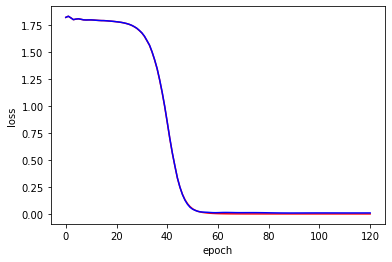

121
Wed Feb  8 23:18:57 2023
train loss: 5.3400439355755225e-05
test loss: 0.009155669249594212
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


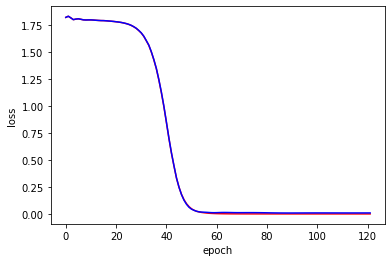

122
Wed Feb  8 23:18:57 2023
train loss: 5.295572555041872e-05
test loss: 0.009195233695209026
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


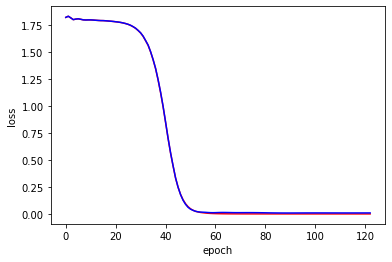

123
Wed Feb  8 23:18:57 2023
train loss: 5.2545223297784105e-05
test loss: 0.009231599047780037
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


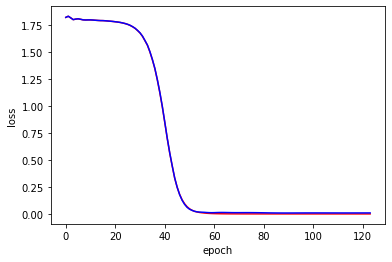

124
Wed Feb  8 23:18:57 2023
train loss: 5.215182318352163e-05
test loss: 0.009261693805456161
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


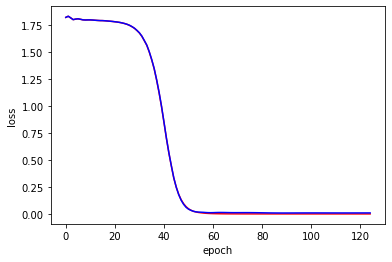

125
Wed Feb  8 23:18:58 2023
train loss: 5.175889964448288e-05
test loss: 0.009286006912589073
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


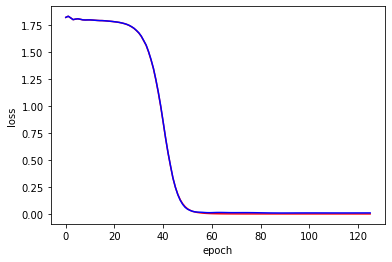

126
Wed Feb  8 23:18:58 2023
train loss: 5.137737389304675e-05
test loss: 0.009306326508522034
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


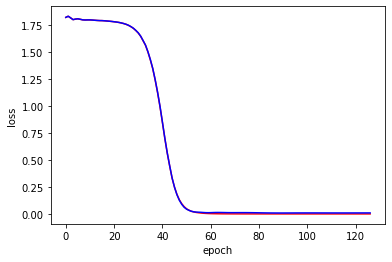

127
Wed Feb  8 23:18:58 2023
train loss: 5.099856571177952e-05
test loss: 0.009322186931967735
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


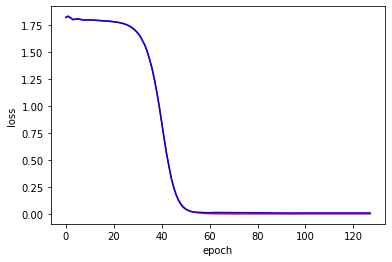

128
Wed Feb  8 23:18:58 2023
train loss: 5.063660864834674e-05
test loss: 0.009334176778793335
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


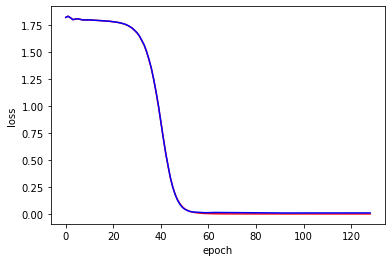

129
Wed Feb  8 23:18:59 2023
train loss: 5.027314546168782e-05
test loss: 0.00933978520333767
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


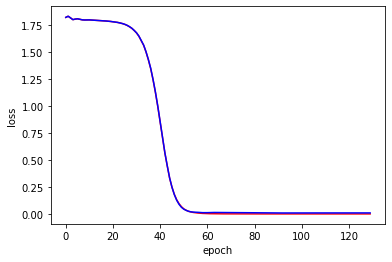

130
Wed Feb  8 23:18:59 2023
train loss: 4.992183676222339e-05
test loss: 0.00934089906513691
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


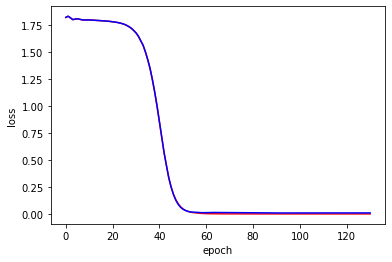

131
Wed Feb  8 23:18:59 2023
train loss: 4.95710082759615e-05
test loss: 0.00933954305946827
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


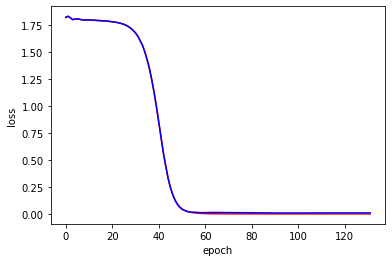

132
Wed Feb  8 23:18:59 2023
train loss: 4.922463995171711e-05
test loss: 0.009335591457784176
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


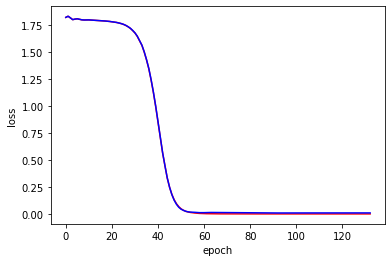

133
Wed Feb  8 23:19:00 2023
train loss: 4.888794137514196e-05
test loss: 0.009330518543720245
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


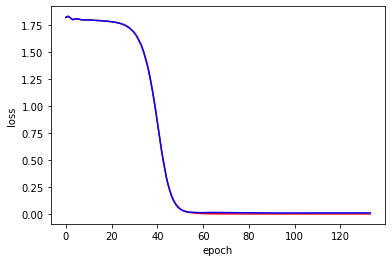

134
Wed Feb  8 23:19:00 2023
train loss: 4.8573823733022436e-05
test loss: 0.009325697086751461
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


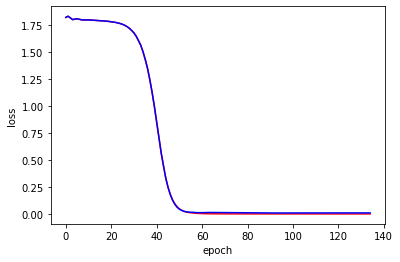

135
Wed Feb  8 23:19:00 2023
train loss: 4.826093572773971e-05
test loss: 0.009319791570305824
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


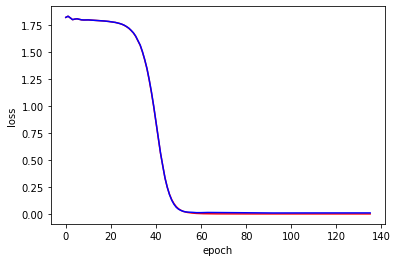

136
Wed Feb  8 23:19:00 2023
train loss: 4.794582127942704e-05
test loss: 0.009312964044511318
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


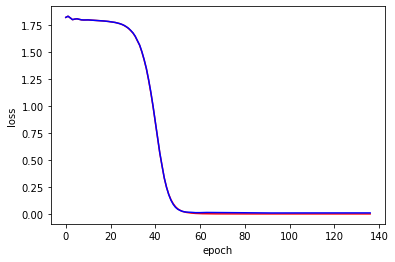

137
Wed Feb  8 23:19:01 2023
train loss: 4.7653287765569985e-05
test loss: 0.009308092296123505
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


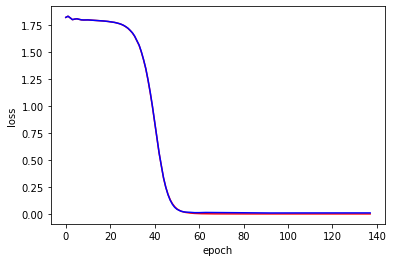

138
Wed Feb  8 23:19:01 2023
train loss: 4.7362002078443766e-05
test loss: 0.009304504841566086
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


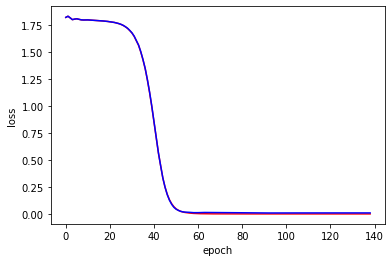

139
Wed Feb  8 23:19:01 2023
train loss: 4.706475374405272e-05
test loss: 0.009302165359258652
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


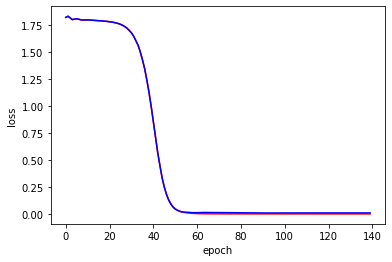

140
Wed Feb  8 23:19:01 2023
train loss: 4.677048491430469e-05
test loss: 0.009300783276557922
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


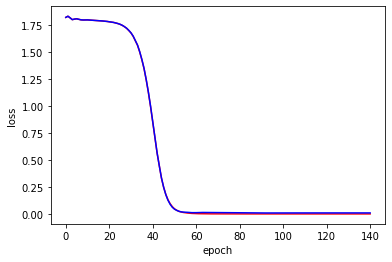

141
Wed Feb  8 23:19:01 2023
train loss: 4.6477467549266294e-05
test loss: 0.00930006243288517
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


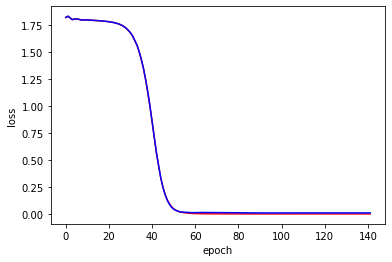

142
Wed Feb  8 23:19:02 2023
train loss: 4.619486935553141e-05
test loss: 0.00930069386959076
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


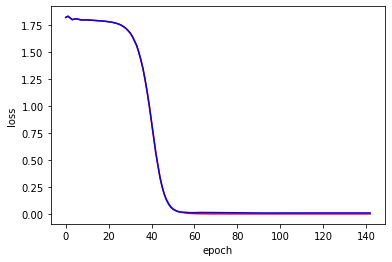

143
Wed Feb  8 23:19:02 2023
train loss: 4.591325705405325e-05
test loss: 0.009301523678004742
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


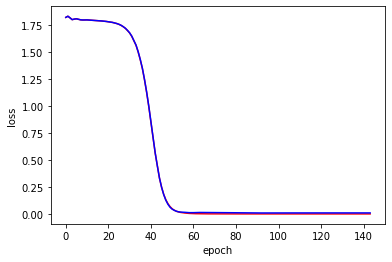

144
Wed Feb  8 23:19:02 2023
train loss: 4.563885158859193e-05
test loss: 0.009302002377808094
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


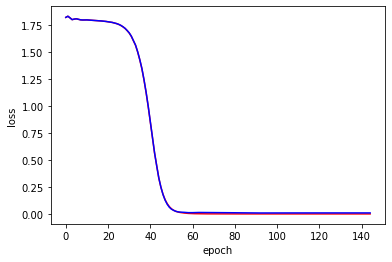

145
Wed Feb  8 23:19:02 2023
train loss: 4.53691573056858e-05
test loss: 0.00930132158100605
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


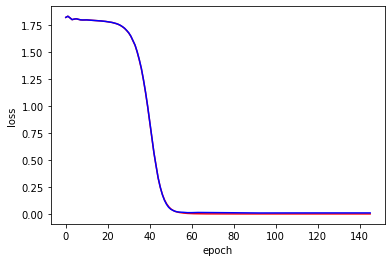

146
Wed Feb  8 23:19:03 2023
train loss: 4.51081468781922e-05
test loss: 0.009301140904426575
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


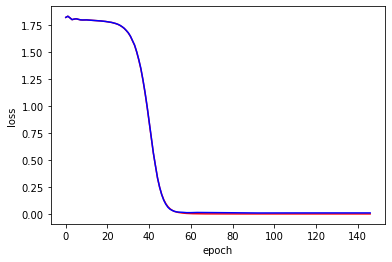

147
Wed Feb  8 23:19:03 2023
train loss: 4.484762393985875e-05
test loss: 0.009304055944085121
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


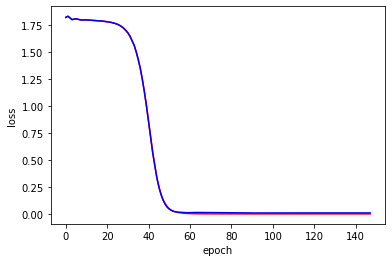

148
Wed Feb  8 23:19:03 2023
train loss: 4.45856130681932e-05
test loss: 0.009307734668254852
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


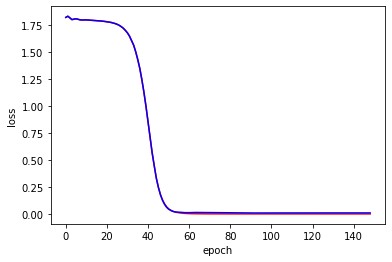

149
Wed Feb  8 23:19:03 2023
train loss: 4.432210334925912e-05
test loss: 0.009309982880949974
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


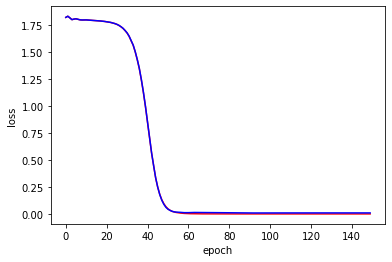

150
Wed Feb  8 23:19:04 2023
train loss: 4.405859363032505e-05
test loss: 0.009311458095908165
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


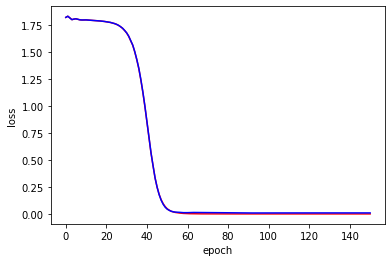

151
Wed Feb  8 23:19:04 2023
train loss: 4.380326936370693e-05
test loss: 0.009313722141087055
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


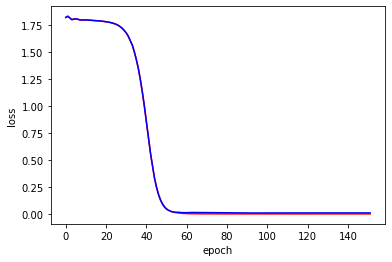

152
Wed Feb  8 23:19:04 2023
train loss: 4.3550669943215325e-05
test loss: 0.009312927722930908
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


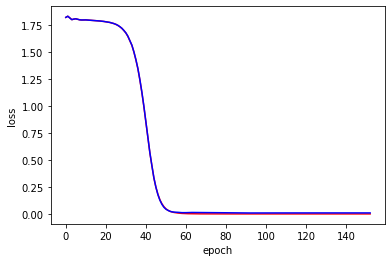

153
Wed Feb  8 23:19:04 2023
train loss: 4.330006777308881e-05
test loss: 0.009310220368206501
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


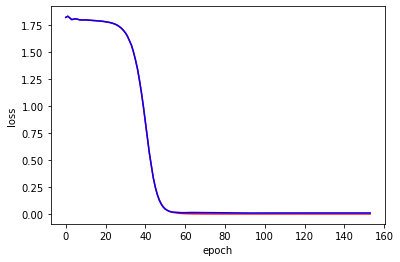

154
Wed Feb  8 23:19:05 2023
train loss: 4.304746835259721e-05
test loss: 0.009306148625910282
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


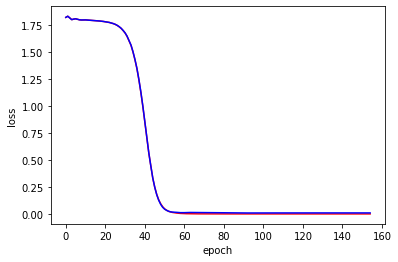

155
Wed Feb  8 23:19:05 2023
train loss: 4.2805047996807843e-05
test loss: 0.009303211234509945
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


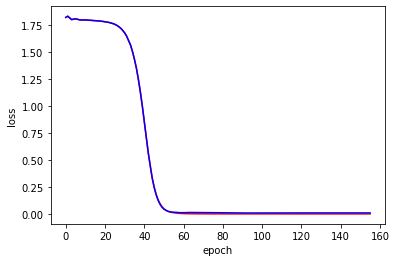

156
Wed Feb  8 23:19:05 2023
train loss: 4.256013926351443e-05
test loss: 0.009301231242716312
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


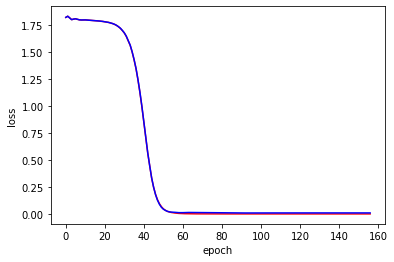

157
Wed Feb  8 23:19:05 2023
train loss: 4.231448838254437e-05
test loss: 0.009299859404563904
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


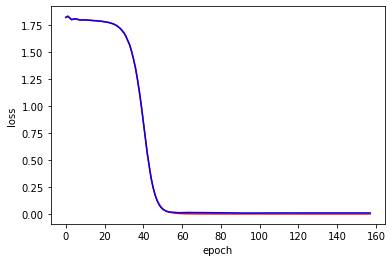

158
Wed Feb  8 23:19:05 2023
train loss: 4.207280289847404e-05
test loss: 0.009299532510340214
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


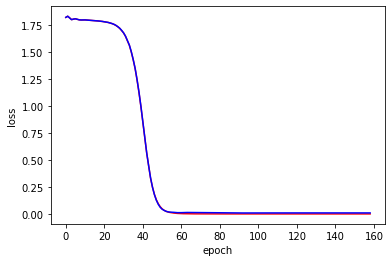

159
Wed Feb  8 23:19:06 2023
train loss: 4.183905548416078e-05
test loss: 0.009298020973801613
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


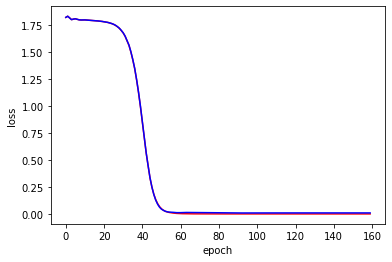

160
Wed Feb  8 23:19:06 2023
train loss: 4.160531170782633e-05
test loss: 0.009295838885009289
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


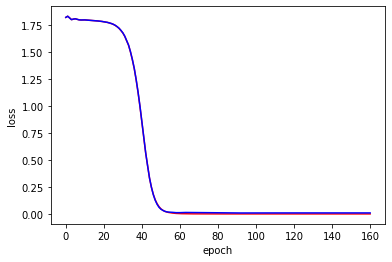

161
Wed Feb  8 23:19:06 2023
train loss: 4.137130599701777e-05
test loss: 0.00929216854274273
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


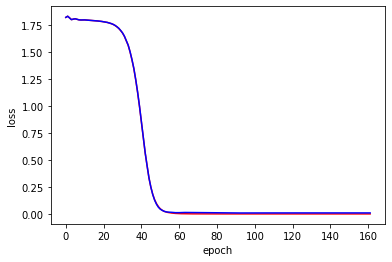

162
Wed Feb  8 23:19:06 2023
train loss: 4.114151670364663e-05
test loss: 0.00928581040352583
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


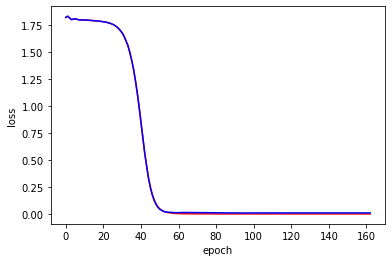

163
Wed Feb  8 23:19:07 2023
train loss: 4.0915710997069255e-05
test loss: 0.009278670884668827
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


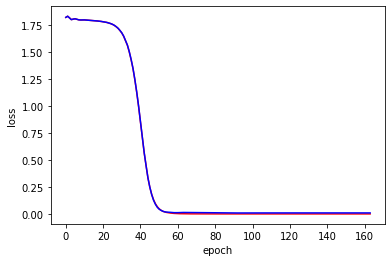

164
Wed Feb  8 23:19:07 2023
train loss: 4.070105933351442e-05
test loss: 0.009273954667150974
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


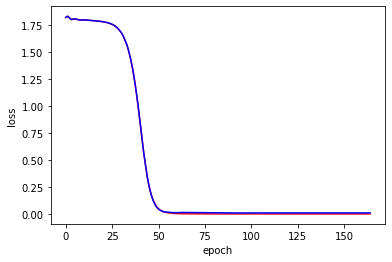

165
Wed Feb  8 23:19:07 2023
train loss: 4.0483439079253e-05
test loss: 0.00927016418427229
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


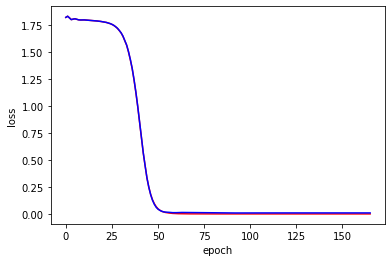

166
Wed Feb  8 23:19:07 2023
train loss: 4.0272760088555515e-05
test loss: 0.009267724119126797
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


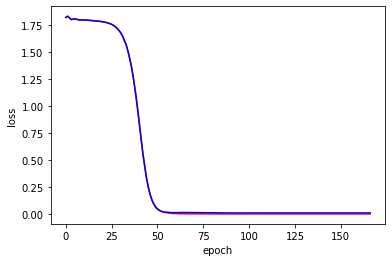

167
Wed Feb  8 23:19:08 2023
train loss: 4.005737355328165e-05
test loss: 0.009264030493795872
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


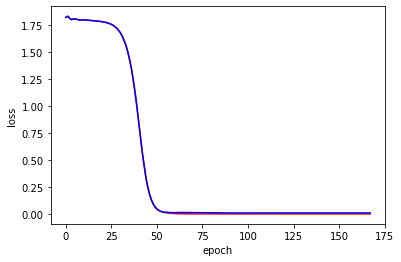

168
Wed Feb  8 23:19:08 2023
train loss: 3.984099021181464e-05
test loss: 0.009259951300919056
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


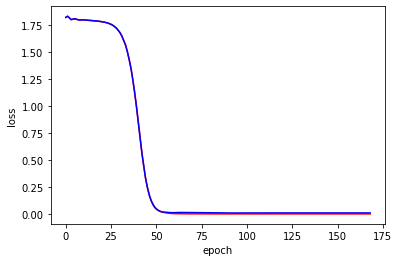

169
Wed Feb  8 23:19:08 2023
train loss: 3.9622867916477844e-05
test loss: 0.009254125878214836
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


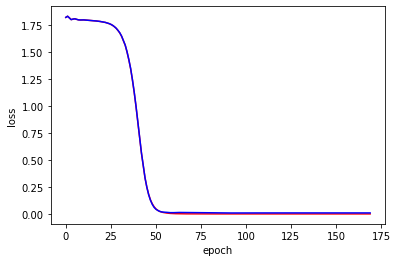

170
Wed Feb  8 23:19:08 2023
train loss: 3.941393151762895e-05
test loss: 0.00924946740269661
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


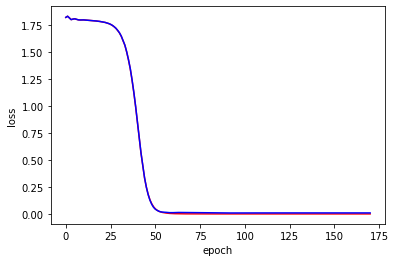

171
Wed Feb  8 23:19:08 2023
train loss: 3.920523522538133e-05
test loss: 0.00924658216536045
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


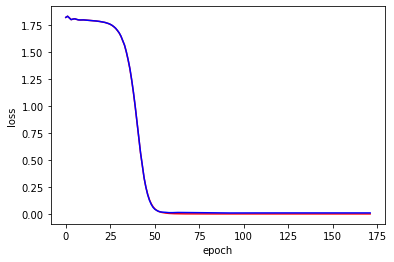

172
Wed Feb  8 23:19:09 2023
train loss: 3.8996789953671396e-05
test loss: 0.009244680404663086
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


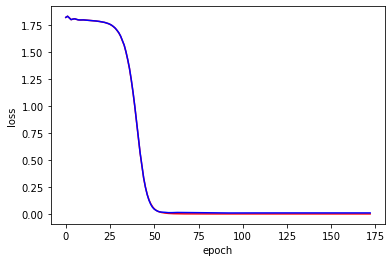

173
Wed Feb  8 23:19:09 2023
train loss: 3.878908682963811e-05
test loss: 0.009243502281606197
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


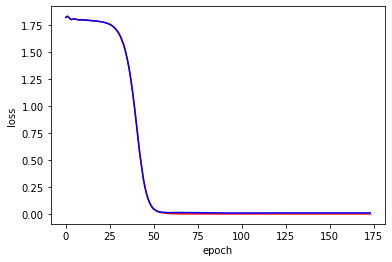

174
Wed Feb  8 23:19:09 2023
train loss: 3.858981290250085e-05
test loss: 0.009243062697350979
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


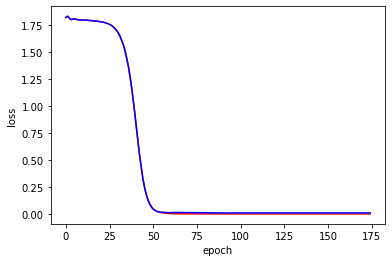

175
Wed Feb  8 23:19:09 2023
train loss: 3.839921919279732e-05
test loss: 0.009242115542292595
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


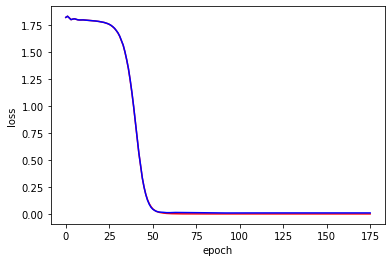

176
Wed Feb  8 23:19:10 2023
train loss: 3.820564961642958e-05
test loss: 0.009238144382834435
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


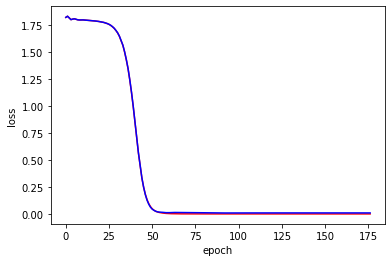

177
Wed Feb  8 23:19:10 2023
train loss: 3.801306593231857e-05
test loss: 0.009233416058123112
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


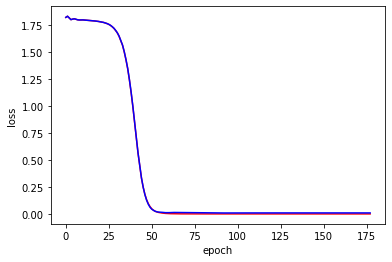

178
Wed Feb  8 23:19:10 2023
train loss: 3.782470230362378e-05
test loss: 0.009229104034602642
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


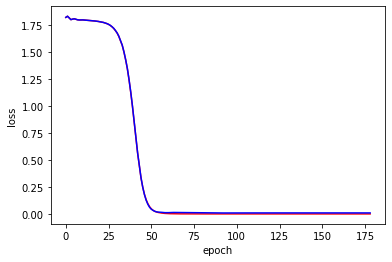

179
Wed Feb  8 23:19:10 2023
train loss: 3.763708446058445e-05
test loss: 0.009226162917912006
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


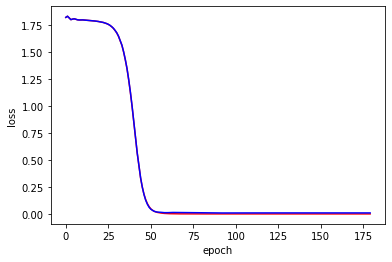

180
Wed Feb  8 23:19:11 2023
train loss: 3.7451201933436096e-05
test loss: 0.009223941713571548
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


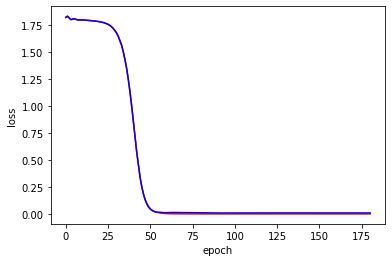

181
Wed Feb  8 23:19:11 2023
train loss: 3.7268295272951946e-05
test loss: 0.009223394095897675
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


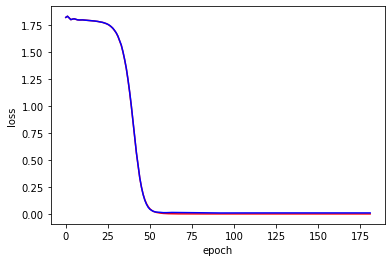

182
Wed Feb  8 23:19:11 2023
train loss: 3.709011434693821e-05
test loss: 0.009222382679581642
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


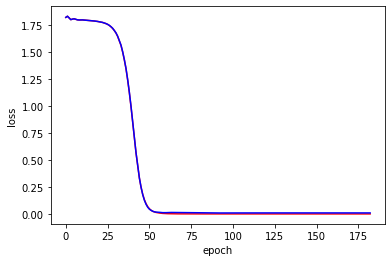

183
Wed Feb  8 23:19:11 2023
train loss: 3.690621451823972e-05
test loss: 0.009222403168678284
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


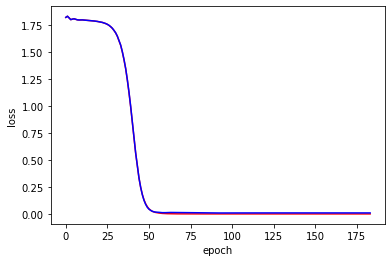

184
Wed Feb  8 23:19:11 2023
train loss: 3.6726043617818505e-05
test loss: 0.009224454872310162
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


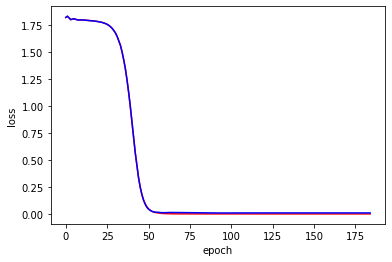

185
Wed Feb  8 23:19:12 2023
train loss: 3.654760803328827e-05
test loss: 0.009224684908986092
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


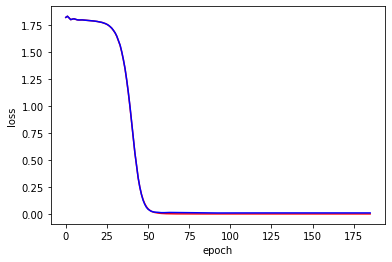

186
Wed Feb  8 23:19:12 2023
train loss: 3.636222390923649e-05
test loss: 0.00922270119190216
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


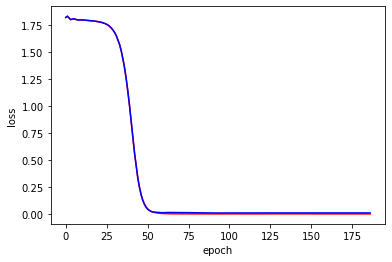

187
Wed Feb  8 23:19:12 2023
train loss: 3.6183038901071995e-05
test loss: 0.009220033884048462
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


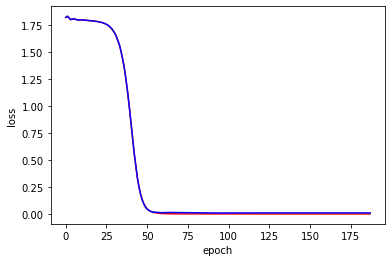

188
Wed Feb  8 23:19:12 2023
train loss: 3.600211493903771e-05
test loss: 0.00921593327075243
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


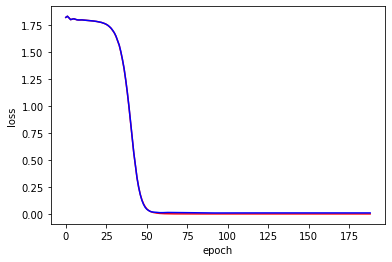

189
Wed Feb  8 23:19:13 2023
train loss: 3.5826156818075106e-05
test loss: 0.00921330600976944
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


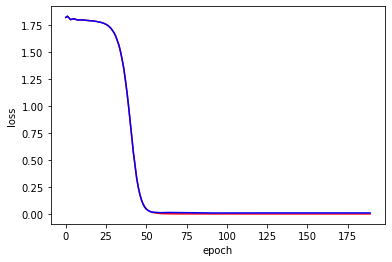

190
Wed Feb  8 23:19:13 2023
train loss: 3.565068982425146e-05
test loss: 0.009211456403136253
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


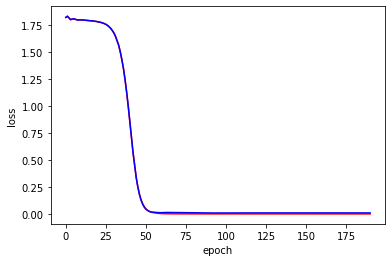

191
Wed Feb  8 23:19:13 2023
train loss: 3.547819869709201e-05
test loss: 0.009210252203047276
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


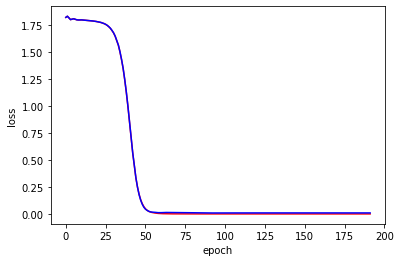

192
Wed Feb  8 23:19:13 2023
train loss: 3.530596586642787e-05
test loss: 0.009209273383021355
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


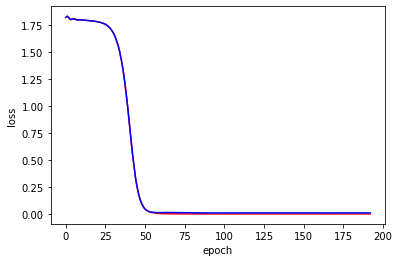

193
Wed Feb  8 23:19:14 2023
train loss: 3.513968476909213e-05
test loss: 0.009208652190864086
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


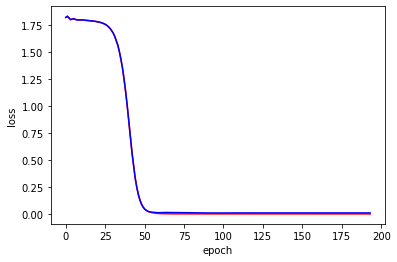

194
Wed Feb  8 23:19:14 2023
train loss: 3.496943463687785e-05
test loss: 0.009207215160131454
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


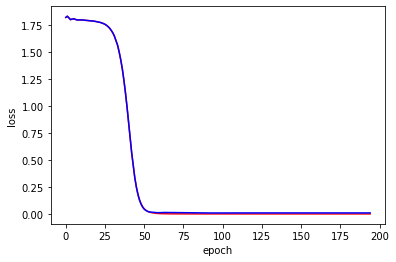

195
Wed Feb  8 23:19:14 2023
train loss: 3.480066152405925e-05
test loss: 0.009205764159560204
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


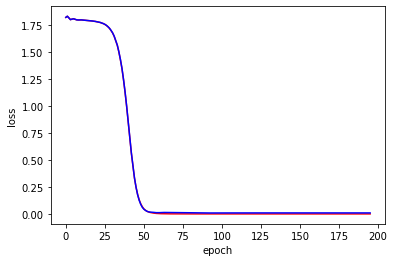

196
Wed Feb  8 23:19:14 2023
train loss: 3.463761095190421e-05
test loss: 0.00920373760163784
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


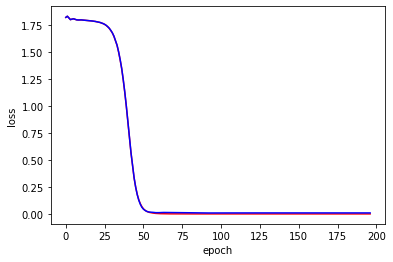

197
Wed Feb  8 23:19:14 2023
train loss: 3.4470082027837634e-05
test loss: 0.009201650507748127
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


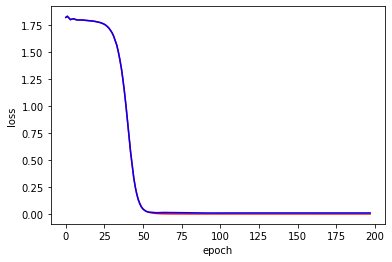

198
Wed Feb  8 23:19:15 2023
train loss: 3.430677315918729e-05
test loss: 0.009198790416121483
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


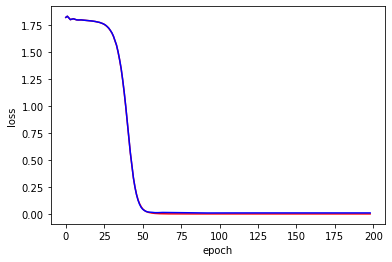

199
Wed Feb  8 23:19:15 2023
train loss: 3.4142722142860293e-05
test loss: 0.009196160361170769
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


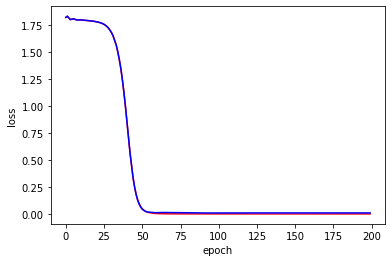

200
Wed Feb  8 23:19:15 2023
train loss: 3.39861107931938e-05
test loss: 0.009193876758217812
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


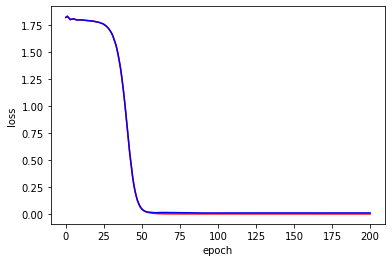

201
Wed Feb  8 23:19:15 2023
train loss: 3.382627255632542e-05
test loss: 0.00919207464903593
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


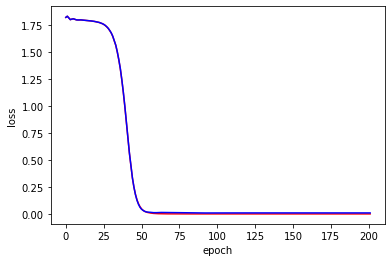

202
Wed Feb  8 23:19:16 2023
train loss: 3.367189856362529e-05
test loss: 0.00919293612241745
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


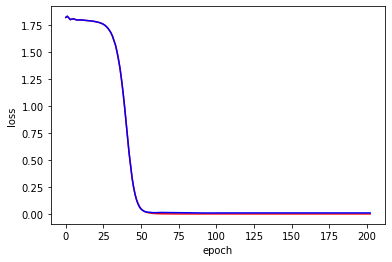

203
Wed Feb  8 23:19:16 2023
train loss: 3.3520009310450405e-05
test loss: 0.009191915392875671
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


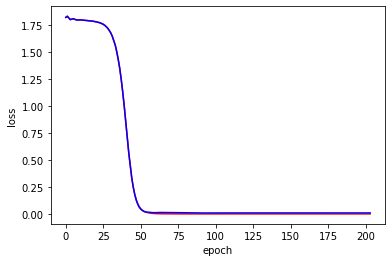

204
Wed Feb  8 23:19:16 2023
train loss: 3.3363397960783914e-05
test loss: 0.009189627133309841
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


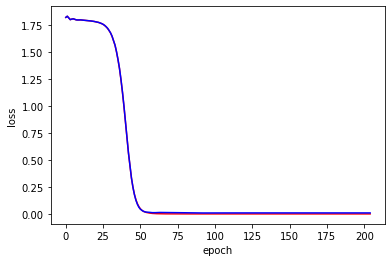

205
Wed Feb  8 23:19:16 2023
train loss: 3.3210260880878195e-05
test loss: 0.009187499061226845
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


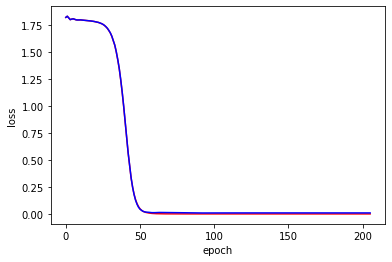

206
Wed Feb  8 23:19:17 2023
train loss: 3.306110011180863e-05
test loss: 0.0091862166300416
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


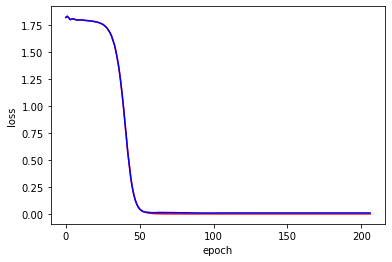

207
Wed Feb  8 23:19:17 2023
train loss: 3.2904739782679826e-05
test loss: 0.009184321388602257
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


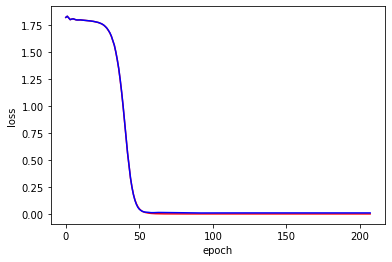

208
Wed Feb  8 23:19:17 2023
train loss: 3.2754822314018384e-05
test loss: 0.009182335808873177
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


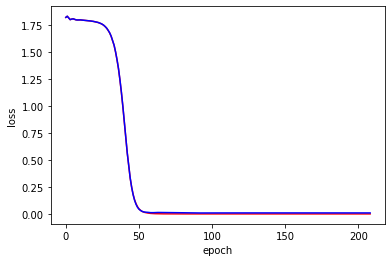

209
Wed Feb  8 23:19:17 2023
train loss: 3.260639641666785e-05
test loss: 0.009181289933621883
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


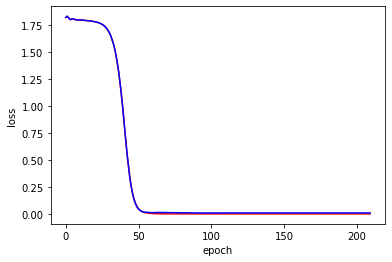

210
Wed Feb  8 23:19:17 2023
train loss: 3.246045162086375e-05
test loss: 0.00917931366711855
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


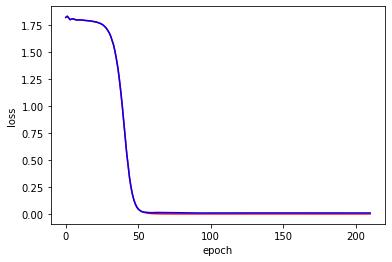

211
Wed Feb  8 23:19:18 2023
train loss: 3.231575101381168e-05
test loss: 0.00917727593332529
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


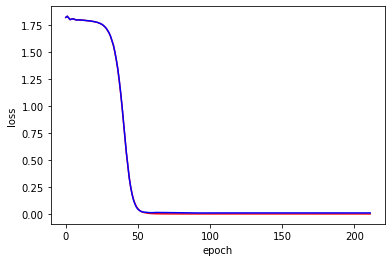

212
Wed Feb  8 23:19:18 2023
train loss: 3.217229095753282e-05
test loss: 0.009175141341984272
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


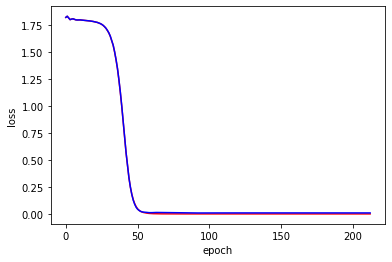

213
Wed Feb  8 23:19:18 2023
train loss: 3.2027834095060825e-05
test loss: 0.00917249545454979
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


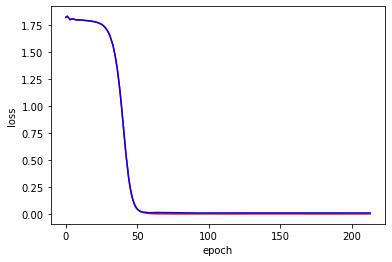

214
Wed Feb  8 23:19:18 2023
train loss: 3.188685514032841e-05
test loss: 0.009171359241008759
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


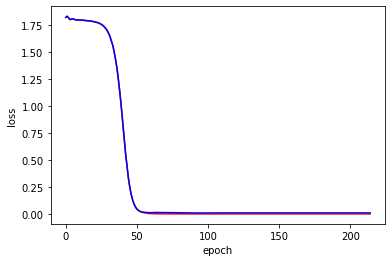

215
Wed Feb  8 23:19:19 2023
train loss: 3.174711673636921e-05
test loss: 0.009171168319880962
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


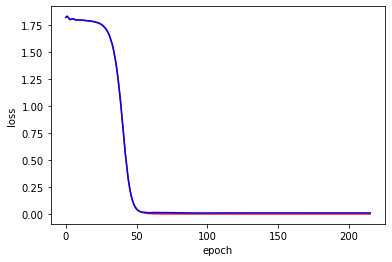

216
Wed Feb  8 23:19:19 2023
train loss: 3.1604642572347075e-05
test loss: 0.0091715008020401
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


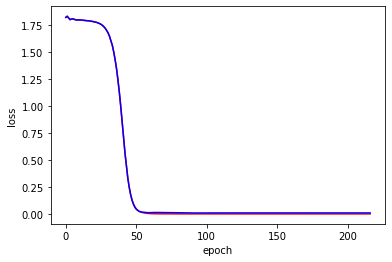

217
Wed Feb  8 23:19:19 2023
train loss: 3.14661483571399e-05
test loss: 0.00917285680770874
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


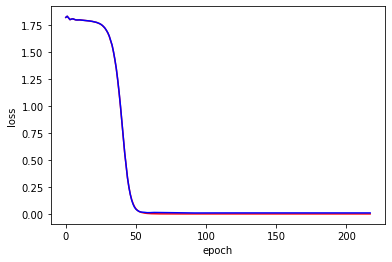

218
Wed Feb  8 23:19:19 2023
train loss: 3.133211430395022e-05
test loss: 0.009175684303045273
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


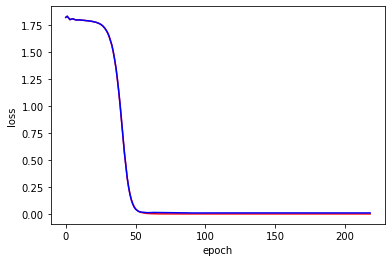

219
Wed Feb  8 23:19:19 2023
train loss: 3.119510074611753e-05
test loss: 0.009176925756037235
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


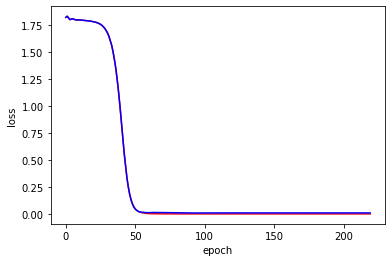

220
Wed Feb  8 23:19:20 2023
train loss: 3.1060073524713516e-05
test loss: 0.009176492691040039
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


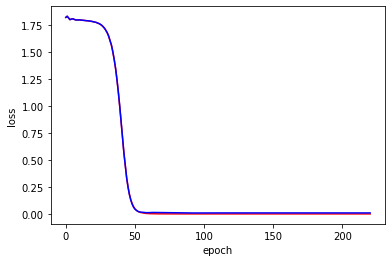

221
Wed Feb  8 23:19:20 2023
train loss: 3.092504994128831e-05
test loss: 0.009173068217933178
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


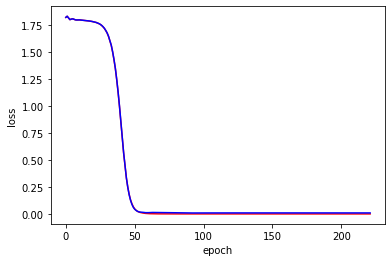

222
Wed Feb  8 23:19:20 2023
train loss: 3.079572707065381e-05
test loss: 0.00916848424822092
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


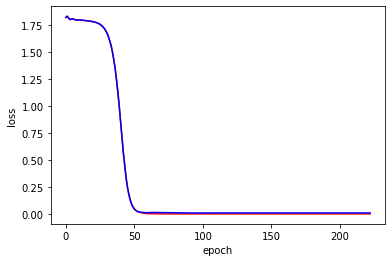

223
Wed Feb  8 23:19:20 2023
train loss: 3.0663926736451685e-05
test loss: 0.009165633469820023
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


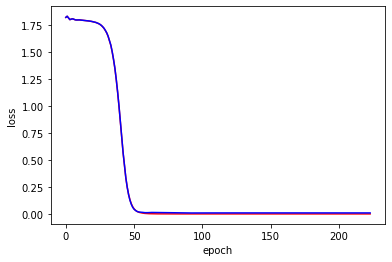

224
Wed Feb  8 23:19:21 2023
train loss: 3.0532621167367324e-05
test loss: 0.009164895862340927
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


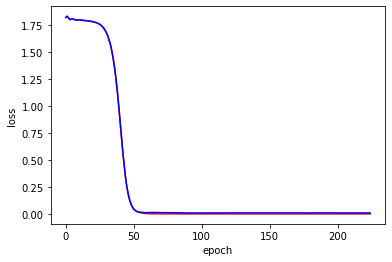

225
Wed Feb  8 23:19:21 2023
train loss: 3.0400322430068627e-05
test loss: 0.009164538234472275
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


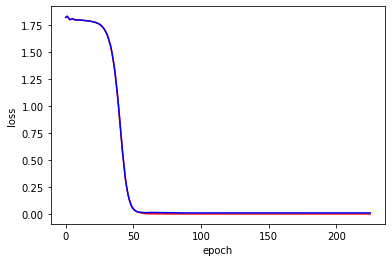

226
Wed Feb  8 23:19:21 2023
train loss: 3.027696038770955e-05
test loss: 0.009167307987809181
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


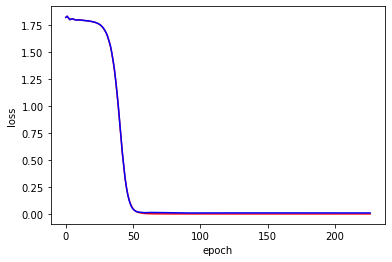

227
Wed Feb  8 23:19:21 2023
train loss: 3.0145407436066307e-05
test loss: 0.009171511046588421
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


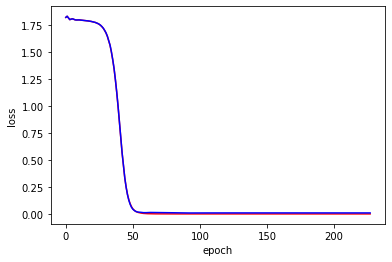

228
Wed Feb  8 23:19:21 2023
train loss: 3.001658660650719e-05
test loss: 0.009176768362522125
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


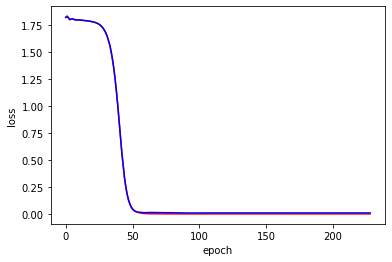

229
Wed Feb  8 23:19:22 2023
train loss: 2.9889255529269576e-05
test loss: 0.009181941859424114
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


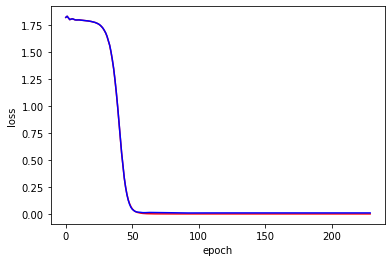

230
Wed Feb  8 23:19:22 2023
train loss: 2.9764156352030113e-05
test loss: 0.009184359572827816
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


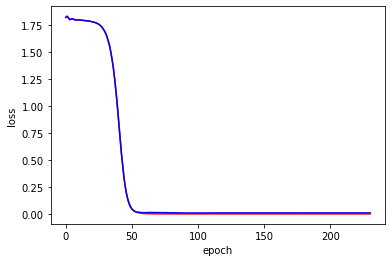

231
Wed Feb  8 23:19:22 2023
train loss: 2.9635828468599357e-05
test loss: 0.009184537455439568
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


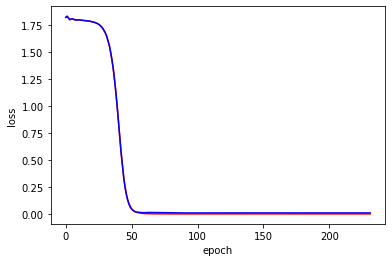

232
Wed Feb  8 23:19:22 2023
train loss: 2.950948510260787e-05
test loss: 0.009184138849377632
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


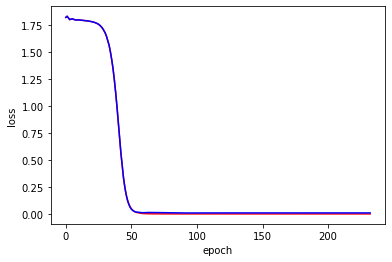

233
Wed Feb  8 23:19:22 2023
train loss: 2.9389098926912993e-05
test loss: 0.009183933958411217
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


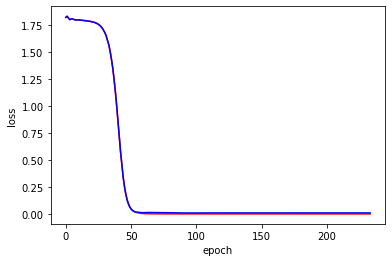

234
Wed Feb  8 23:19:23 2023
train loss: 2.9270697268657386e-05
test loss: 0.009184809401631355
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


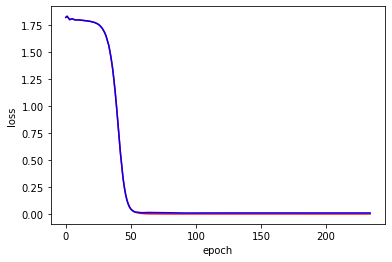

235
Wed Feb  8 23:19:23 2023
train loss: 2.914286233135499e-05
test loss: 0.009186822921037674
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


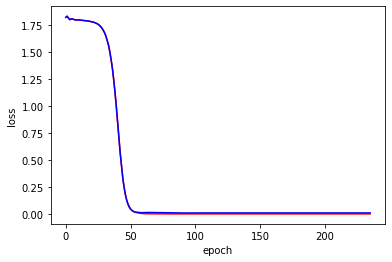

236
Wed Feb  8 23:19:23 2023
train loss: 2.90271873382153e-05
test loss: 0.009187337942421436
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


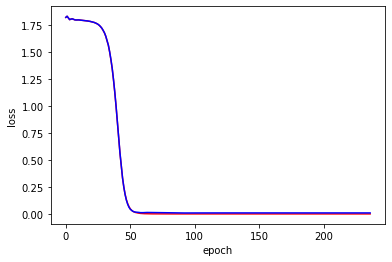

237
Wed Feb  8 23:19:23 2023
train loss: 2.8907295927638188e-05
test loss: 0.009186271578073502
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


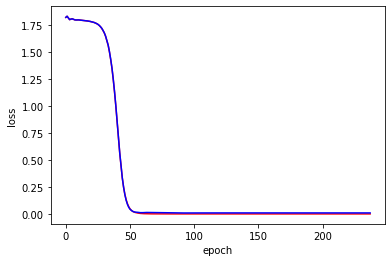

238
Wed Feb  8 23:19:24 2023
train loss: 2.8784676032955758e-05
test loss: 0.00918427761644125
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


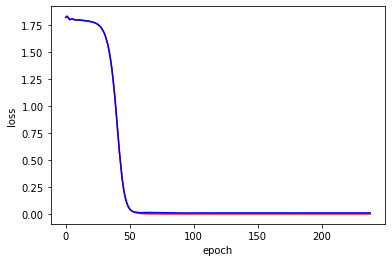

239
Wed Feb  8 23:19:24 2023
train loss: 2.8664537239819765e-05
test loss: 0.009182393550872803
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


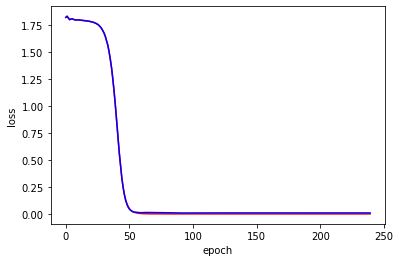

240
Wed Feb  8 23:19:24 2023
train loss: 2.8543652661028318e-05
test loss: 0.009179500862956047
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


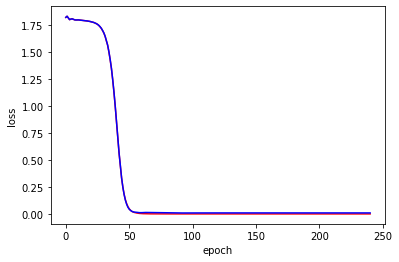

241
Wed Feb  8 23:19:24 2023
train loss: 2.842872345354408e-05
test loss: 0.00917628314346075
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


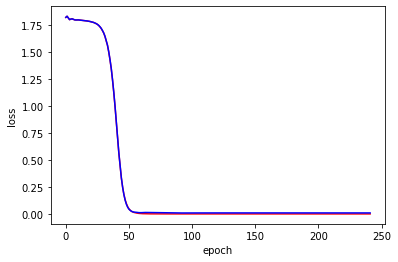

242
Wed Feb  8 23:19:25 2023
train loss: 2.8314041628618725e-05
test loss: 0.009171247482299805
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


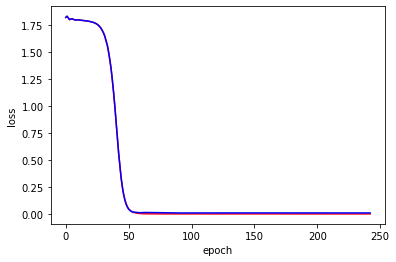

243
Wed Feb  8 23:19:25 2023
train loss: 2.8191168894409202e-05
test loss: 0.009167545475065708
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


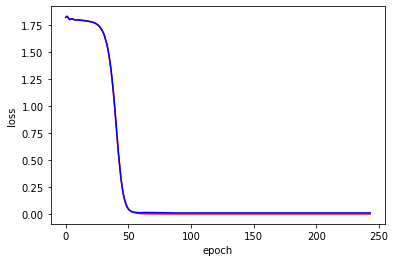

244
Wed Feb  8 23:19:25 2023
train loss: 2.8074502552044578e-05
test loss: 0.009166337549686432
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


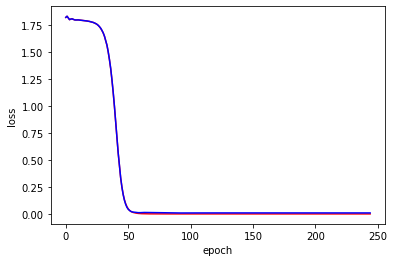

245
Wed Feb  8 23:19:25 2023
train loss: 2.7956097255810164e-05
test loss: 0.009167452342808247
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


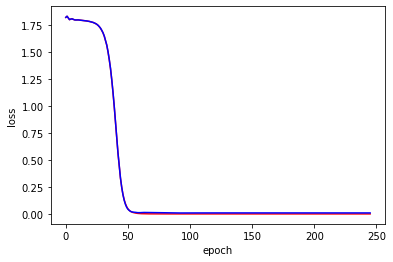

246
Wed Feb  8 23:19:25 2023
train loss: 2.7837695597554557e-05
test loss: 0.009170334786176682
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


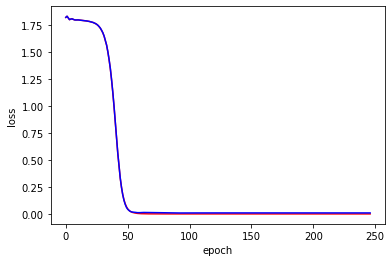

247
Wed Feb  8 23:19:26 2023
train loss: 2.772475272649899e-05
test loss: 0.009173906408250332
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


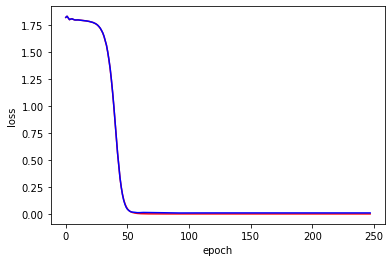

248
Wed Feb  8 23:19:26 2023
train loss: 2.761057112365961e-05
test loss: 0.009175751358270645
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


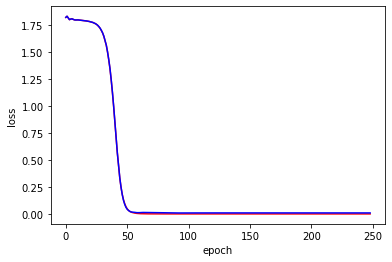

249
Wed Feb  8 23:19:26 2023
train loss: 2.749688246694859e-05
test loss: 0.009175457991659641
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


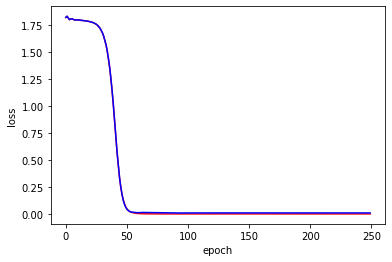

250
Wed Feb  8 23:19:26 2023
train loss: 2.7388654416427016e-05
test loss: 0.009174156002700329
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


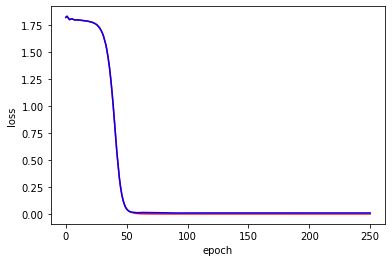

251
Wed Feb  8 23:19:27 2023
train loss: 2.7274960302747786e-05
test loss: 0.009171523153781891
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


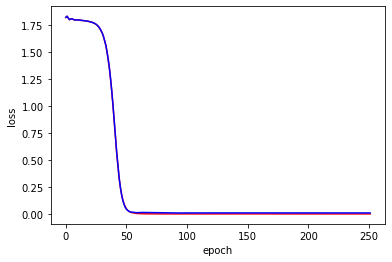

252
Wed Feb  8 23:19:27 2023
train loss: 2.716598828556016e-05
test loss: 0.00917046144604683
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


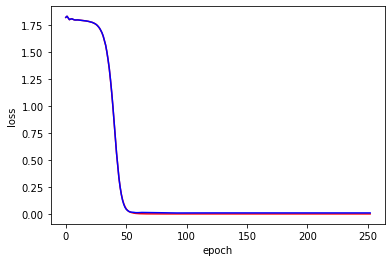

253
Wed Feb  8 23:19:27 2023
train loss: 2.7055528335040435e-05
test loss: 0.00917043350636959
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


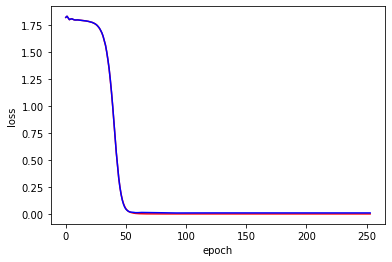

254
Wed Feb  8 23:19:27 2023
train loss: 2.6946552679874003e-05
test loss: 0.009170657023787498
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


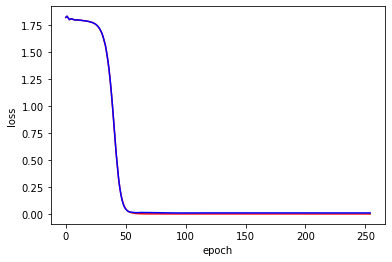

255
Wed Feb  8 23:19:27 2023
train loss: 2.6839072233997285e-05
test loss: 0.009171100333333015
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


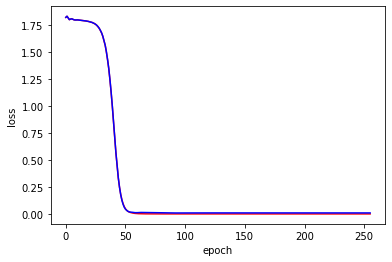

256
Wed Feb  8 23:19:28 2023
train loss: 2.6729603632702492e-05
test loss: 0.00916852056980133
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


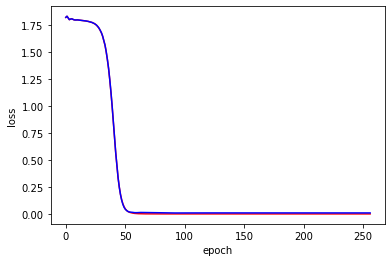

257
Wed Feb  8 23:19:28 2023
train loss: 2.6625848477124237e-05
test loss: 0.009161299094557762
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


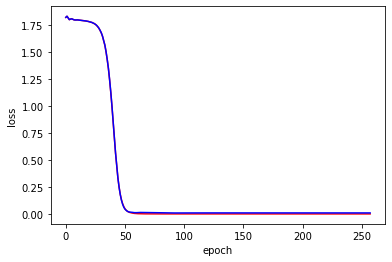

258
Wed Feb  8 23:19:28 2023
train loss: 2.6520847313804552e-05
test loss: 0.009153276681900024
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


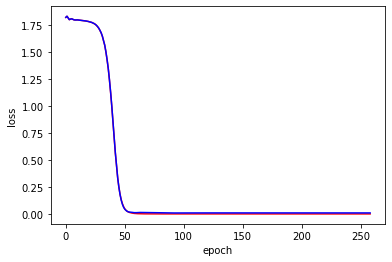

259
Wed Feb  8 23:19:28 2023
train loss: 2.6417836124892347e-05
test loss: 0.00914553552865982
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


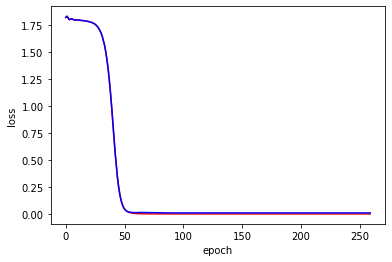

260
Wed Feb  8 23:19:29 2023
train loss: 2.6315314244129695e-05
test loss: 0.009139138273894787
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


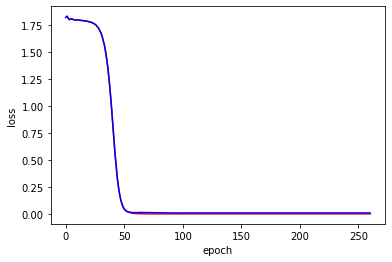

261
Wed Feb  8 23:19:29 2023
train loss: 2.621254498080816e-05
test loss: 0.009131202474236488
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


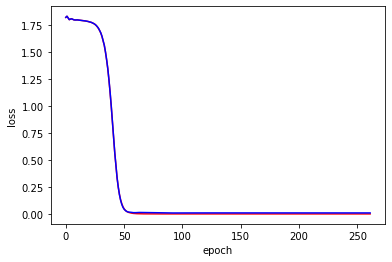

262
Wed Feb  8 23:19:29 2023
train loss: 2.611226045701187e-05
test loss: 0.009124317206442356
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


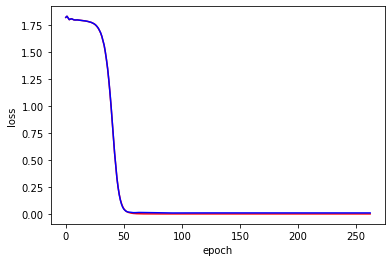

263
Wed Feb  8 23:19:29 2023
train loss: 2.600725565571338e-05
test loss: 0.009118775837123394
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


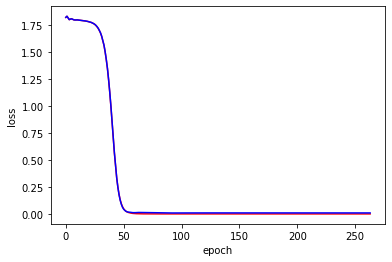

264
Wed Feb  8 23:19:29 2023
train loss: 2.5906721930368803e-05
test loss: 0.009112635627388954
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


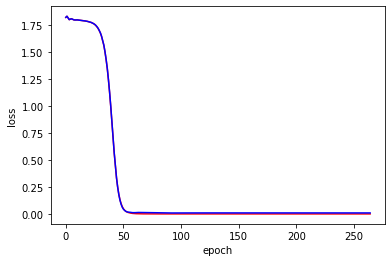

265
Wed Feb  8 23:19:30 2023
train loss: 2.580717955424916e-05
test loss: 0.009103486314415932
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


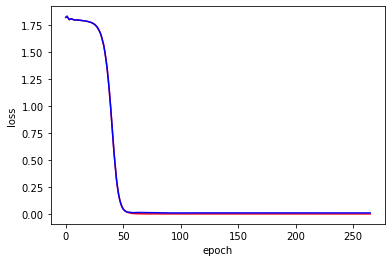

266
Wed Feb  8 23:19:30 2023
train loss: 2.57078845606884e-05
test loss: 0.009094358421862125
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


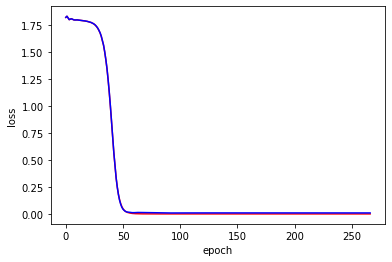

267
Wed Feb  8 23:19:30 2023
train loss: 2.5608091164031066e-05
test loss: 0.009084546938538551
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


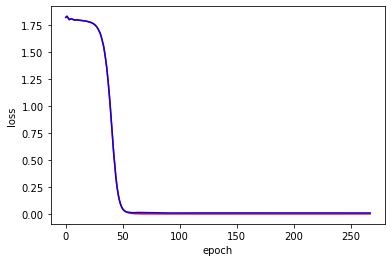

268
Wed Feb  8 23:19:30 2023
train loss: 2.5511777494102716e-05
test loss: 0.009075763635337353
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


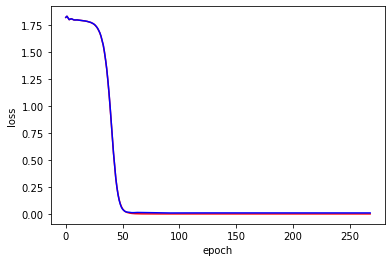

269
Wed Feb  8 23:19:31 2023
train loss: 2.5415210984647274e-05
test loss: 0.009066667407751083
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


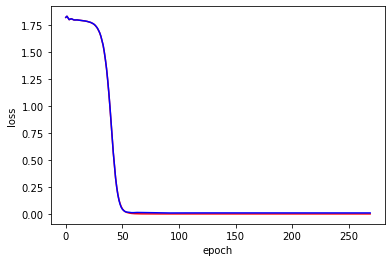

270
Wed Feb  8 23:19:31 2023
train loss: 2.5321625798824243e-05
test loss: 0.00905817560851574
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


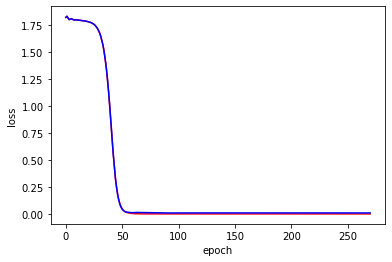

271
Wed Feb  8 23:19:31 2023
train loss: 2.5224066121154465e-05
test loss: 0.009050881490111351
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


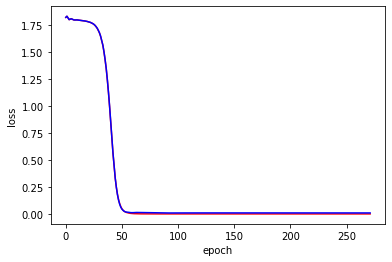

272
Wed Feb  8 23:19:31 2023
train loss: 2.513047911634203e-05
test loss: 0.009043904952704906
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


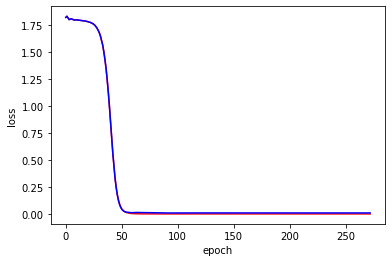

273
Wed Feb  8 23:19:31 2023
train loss: 2.5038880266947672e-05
test loss: 0.009037215262651443
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


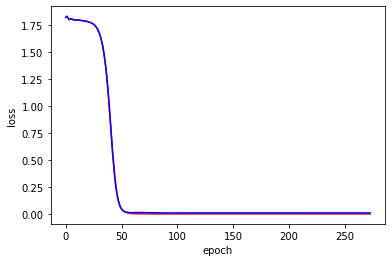

274
Wed Feb  8 23:19:32 2023
train loss: 2.4947776182671078e-05
test loss: 0.009031410329043865
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


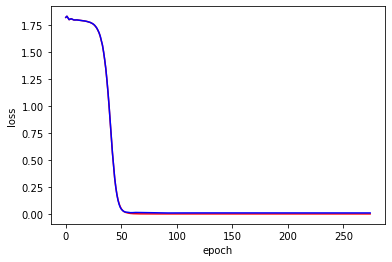

275
Wed Feb  8 23:19:32 2023
train loss: 2.485394179529976e-05
test loss: 0.009025884792208672
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


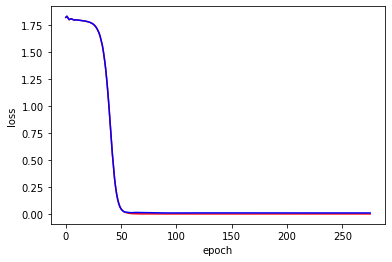

276
Wed Feb  8 23:19:32 2023
train loss: 2.4760851374594495e-05
test loss: 0.009021937847137451
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


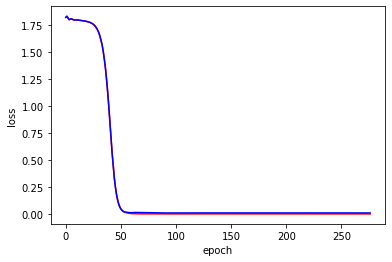

277
Wed Feb  8 23:19:32 2023
train loss: 2.4667759134899825e-05
test loss: 0.009014427661895752
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


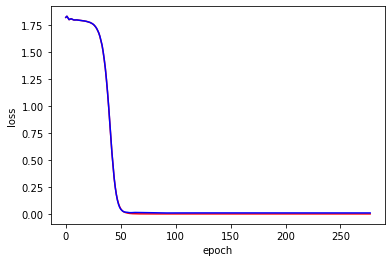

278
Wed Feb  8 23:19:33 2023
train loss: 2.4573426344431937e-05
test loss: 0.00900560524314642
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


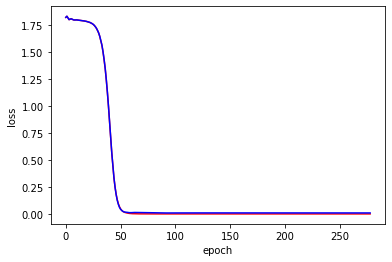

279
Wed Feb  8 23:19:33 2023
train loss: 2.448281884426251e-05
test loss: 0.00899722520262003
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


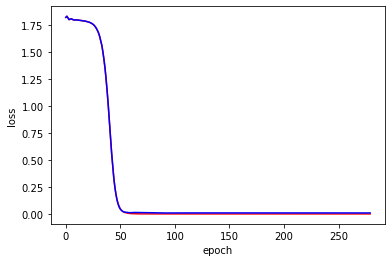

280
Wed Feb  8 23:19:33 2023
train loss: 2.439246054564137e-05
test loss: 0.008993586525321007
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


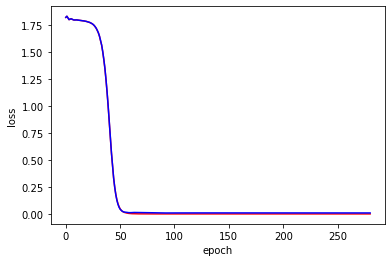

281
Wed Feb  8 23:19:33 2023
train loss: 2.4302598831127398e-05
test loss: 0.008990895003080368
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


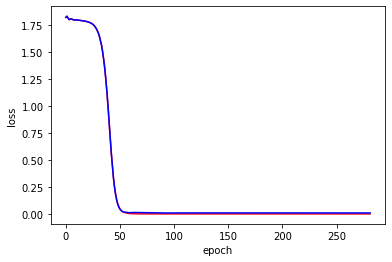

282
Wed Feb  8 23:19:33 2023
train loss: 2.4212735297624022e-05
test loss: 0.008986483328044415
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


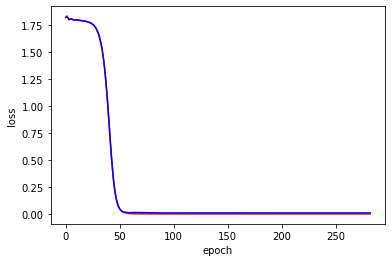

283
Wed Feb  8 23:19:34 2023
train loss: 2.41265934164403e-05
test loss: 0.00897796917706728
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


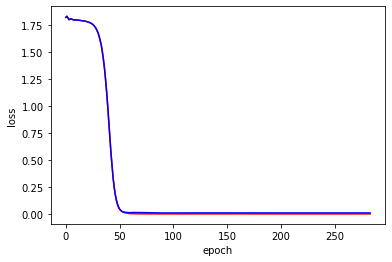

284
Wed Feb  8 23:19:34 2023
train loss: 2.404045153525658e-05
test loss: 0.008967658504843712
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


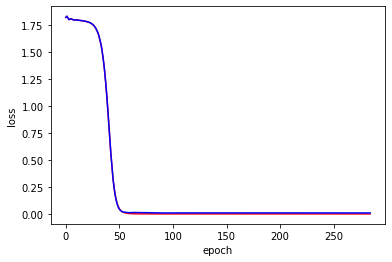

285
Wed Feb  8 23:19:34 2023
train loss: 2.395331466686912e-05
test loss: 0.008958561345934868
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


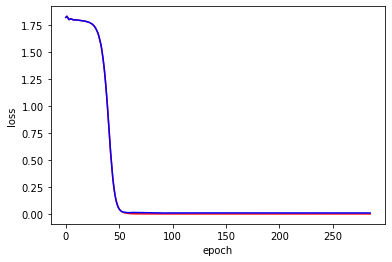

286
Wed Feb  8 23:19:34 2023
train loss: 2.3869162760092877e-05
test loss: 0.008951359428465366
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


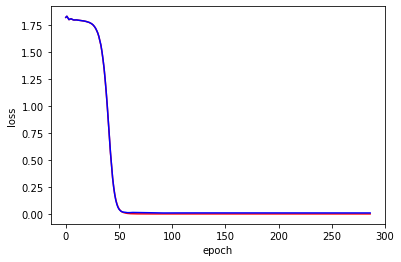

287
Wed Feb  8 23:19:35 2023
train loss: 2.3782522475812584e-05
test loss: 0.008944821543991566
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


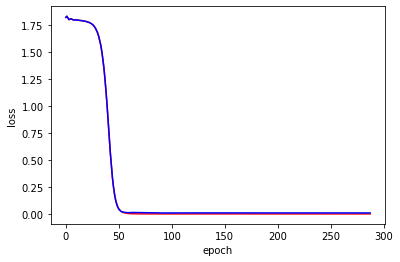

288
Wed Feb  8 23:19:35 2023
train loss: 2.3696382413618267e-05
test loss: 0.008938931860029697
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


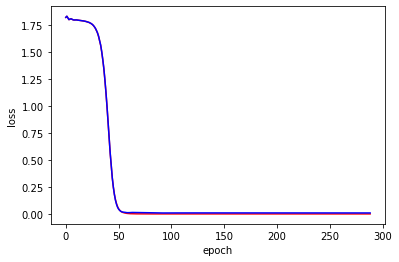

289
Wed Feb  8 23:19:35 2023
train loss: 2.361396764172241e-05
test loss: 0.008933864533901215
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


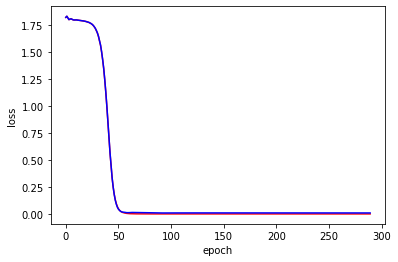

290
Wed Feb  8 23:19:35 2023
train loss: 2.3529562895419076e-05
test loss: 0.00892757810652256
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


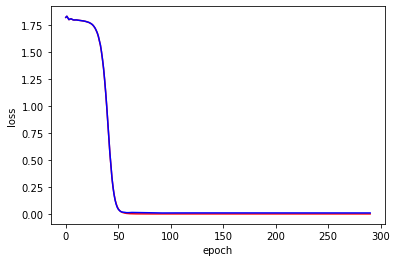

291
Wed Feb  8 23:19:35 2023
train loss: 2.3447639250662178e-05
test loss: 0.008919935673475266
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


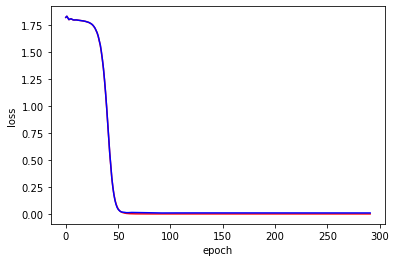

292
Wed Feb  8 23:19:36 2023
train loss: 2.336621400900185e-05
test loss: 0.00891057774424553
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


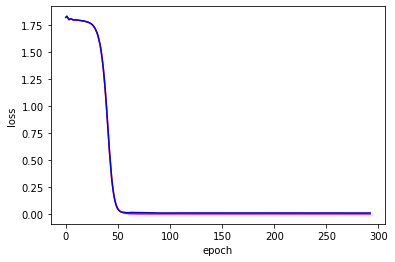

293
Wed Feb  8 23:19:36 2023
train loss: 2.328627851966303e-05
test loss: 0.008903180249035358
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


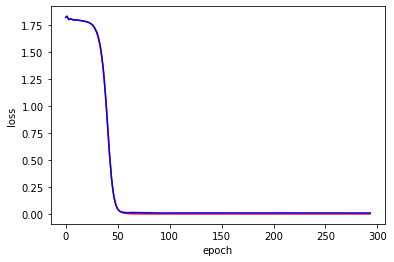

294
Wed Feb  8 23:19:36 2023
train loss: 2.3204604076454416e-05
test loss: 0.00889635644853115
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


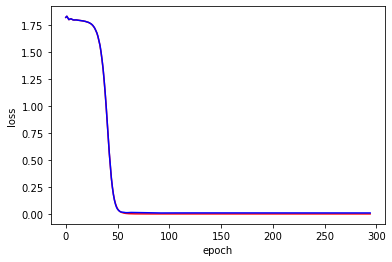

295
Wed Feb  8 23:19:36 2023
train loss: 2.312417018401902e-05
test loss: 0.008891564793884754
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


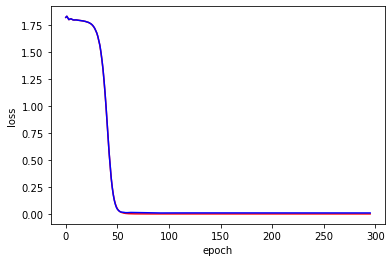

296
Wed Feb  8 23:19:37 2023
train loss: 2.3042000975692645e-05
test loss: 0.008887377567589283
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


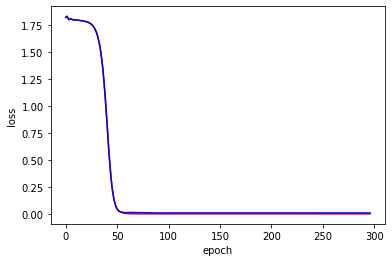

297
Wed Feb  8 23:19:37 2023
train loss: 2.2960821297601797e-05
test loss: 0.008881776593625546
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


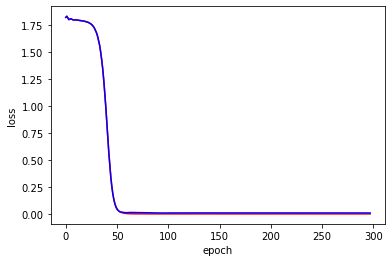

298
Wed Feb  8 23:19:37 2023
train loss: 2.2885853468324058e-05
test loss: 0.00887383334338665
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


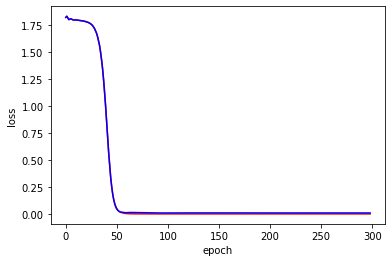

299
Wed Feb  8 23:19:37 2023
train loss: 2.2808397261542268e-05
test loss: 0.008865063078701496
predict right count in train: tensor(480, device='cuda:0')
predict right count in test: tensor(298, device='cuda:0')


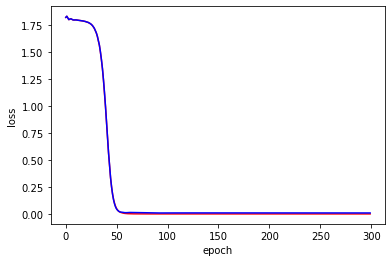

In [20]:
losses = []
losses_test = []

train_right_pre = []
test_right_pre = []

for epoch in range(300):
    
    print(epoch)
    print(time.asctime())
    
    net.eval()
    with torch.no_grad():
        pred_y_test = net(test_x)
        
        loss_test = loss_function(pred_y_test, test_y)
        
        losses_test.append(loss_test.item())
        
        test_right_pred = (m2(m1(pred_y_test
                                )
                             ).argmax(1) == test_y.argmax(1)).sum()
        
        test_right_pre.append(test_right_pred)
    
    net.train()
    pred_y = net(train_x)
    
    loss = loss_function(pred_y, train_y)

    losses.append(loss.item())
    
    train_right_pred = (m2(m1(pred_y
                                )
                             ).argmax(1) == train_y.argmax(1)).sum()
    train_right_pre.append(train_right_pred)
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    plt.plot(losses, 'r')
    plt.plot(losses_test, 'b')
    plt.ylabel('loss')
    plt.xlabel('epoch')
#     plt.title('Train')

    print('train loss: ' + str(losses[-1]))
    print('test loss: ' + str(losses_test[-1]))
    print('predict right count in train: ' + str(train_right_pre[-1]))
    print('predict right count in test: ' + str(test_right_pre[-1]))
    
    plt.show()

#     torch.save(net.state_dict(), '/data/docker_qiime2_share_G/Hejunwei/core_genome_study/CNN/no_dataloaderr_models/'
#                + str(epoch) 
#                +'_epoch_.pth')

In [21]:
print(len(train_set))
print(len(test_set))

480
300


In [22]:
min(losses_test)

0.008508631028234959

In [23]:
min(losses)

2.2808397261542268e-05

In [24]:
losses_test.index(min(losses_test
                     )
                 )

89

In [25]:
losses.index(min(losses
                )
            )

299

In [26]:
max(train_right_pre)

tensor(480, device='cuda:0')

In [27]:
max(test_right_pre)

tensor(298, device='cuda:0')

In [28]:
train_right_pre.index(max(train_right_pre
                     )
                 )

54

In [29]:
test_right_pre.index(max(test_right_pre
                     )
                 )

47

# get kernel and transform into DNA

In [30]:
the_very_first_layer = net.conv1.weight

In [31]:
the_very_first_layer[0][0].shape[1]

46

In [32]:
the_very_first_layer[0][0][:, 0].argmax().item()

2

In [33]:
the_very_first_layer.shape

torch.Size([6, 1, 4, 46])

In [34]:
conv_d = {
    0: 'A',
    1: 'T',
    2: 'C',
    3: 'G'
}

d_kernels = {}

s = 0

for a_kernel in the_very_first_layer:
    the_only_channel = a_kernel[0]
    col_len = the_only_channel.shape[1]
    
    a_seq = ''
    for cols in range(col_len):
        base = the_only_channel[:, cols].argmax().item()
        
        a_seq = a_seq + conv_d[base]
        
    d_kernels[s] = a_seq
    
    s += 1

In [35]:
d_kernels

{0: 'CAAGTCGGTAGCTCCTGCGCTATTTGCCCTGATCATCGGCGGTTAC',
 1: 'CGGGTCTTAAAGATTCAGTTATTAGCCCCACCCCACGTTTATTTAC',
 2: 'CCCTCGAATCCTTAGACCGTTTAGCTTAGTGAATGGACAGAGACAA',
 3: 'CGGATCATACTGTTTGAAAAGGACGCCTTTATCGTACATCGGAATC',
 4: 'TCAGCCGGCACTTCGCCGCAGGCTATACCACCCCGAATTCGAGACA',
 5: 'CTCAGTGAAAATCCCGAAATCGCCTGCTGAACTGAACGGTTTCTCC'}